In [231]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys
import string

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-04 20:00:00    305.3    305.3   305.3     305.3      149.0
2022-02-04 19:59:00    305.2    305.2   305.2     305.2      571.0


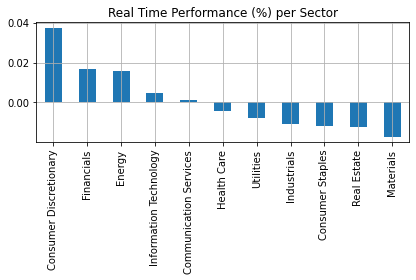

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

137.1500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
128     DGRO
129     TD6C
130     TDG0
131    PTTRX
132      NaN
Name: Ticker, Length: 133, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
16-Feb
26-Jan - UP (228.2200)
16-Feb
21-Feb
28-Feb
23-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
03-Feb - UP (138.1800)
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
14-Feb
16-Feb
15-Feb
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
10-Feb
21-Feb
01-Feb - UP (128.4400)
18-Feb
01-Mar
02-Feb - DN (237.7600)
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb - UP (38.9100)
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
05-Feb
10-Feb
23-Feb
09-

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [119]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [198]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace("•", np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("•", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [92]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [95]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  $(86.0)  $(27.5)     $(58.5)
5                Non-GAAP Operating Loss  $(36.8)  $(20.4)     $(16.4)
6                GAAP Net Loss Per Share  $(0.74)  $(0.25)     $(0.49)
7            Non-GAAP Net Loss Per Share  $(0.31)  $(0.19)     $(0.12)
8  Net Cash Used in Operating Activities  $(43.2)  $(21.5)     $(21.7)
9                         Free Cash Flow  $(45.4)  $(22.7)     $(22.7)
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q2 2021  Q2 2020 Y/Y CHANGE

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP OPERATING LOSS TO NON-G...   
4                      OPERATING LOSS ON A GAAP BASIS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
7        ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
8                             NON-GAAP OPERATING LOSS   
9                           NON-GAAP OPERATING MARGIN   
11  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
12                           NET LOSS ON A GAAP BASIS   
13               ADD STOCK-BASED COMPENSATION EXPENSE   
14  ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
15       ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
16             ADD INCOME TAX EFFECTS AND ADJUSTMENTS   
17                                  NON-GAAP NET LOSS   
18  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   
19  WEIGHTED

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-02-15
None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [219]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Earning report for stock ENB on date 2022-02-11 does not exist, trying to fetch it
Earning report for stock ENB fetching status False, filename None
Quote for stock ENB on earning date 11-Feb not generated yet
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning for stock KNSL will be released later on 2022-02-17
Quote for stock KNSL on earning date 17-Feb not generated yet
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning for stock APPN will be released later o

FOR TABLE 1

TABLE DESCRIPTION: , RISK FACTORS RELATING TO THE COVID-19 GLOBAL OUTBREAK AND OUR FUTURE PUBLIC FILINGS. INMODE UNDERTAKES NO OBLIGATION AND DOES NOT INTEND TO UPDATE THESE FORWARD-LOOKING STATEMENTS TO REFLECT EVENTS OR CIRCUMSTANCES OCCURRING AFTER THIS PRESS RELEASE. YOU ARE CAUTIONED NOT TO PLACE UNDUE RELIANCE ON THESE FORWARD-LOOKING STATEMENTS, WHICH PERTAIN ONLY AS OF THE DATE OF THIS PRESS RELEASE.
ORIGINAL TABLE  1
                                                   0  \
0  Company Contact:Yair MalcaChief Financial Offi...   

                                                   1  
0  Investor Relations Contact:Miri SegalMS-IR LLC...  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: <BR/>
ORIGINAL TABLE  2
                                                    0  \
0                                         INMODE LTD.   
1         CONDENSED CONSOLIDATED STATEMENTS OF INCOME   
2   (U.S. dollars in thousands, except for per sha...  

39                                              68938  
HEADERSSSSSSSSS ['0:5']
{}

FINAL REPORT
                                               METRIC  \
7                CASH FLOWS FROM OPERATING ACTIVITIES   
8                                          NET INCOME   
9   ADJUSTMENTS REQUIRED TO RECONCILE NET INCOME T...   
10                      DEPRECIATION AND AMORTIZATION   
11                  SHARE-BASED COMPENSATION EXPENSES   
12                    ALLOWANCE FOR DOUBTFUL ACCOUNTS   
13                 LOSS ON MARKETABLE SECURITIES, NET   
14                     FINANCE EXPENSES (INCOME), NET   
15                         DEFERRED INCOME TAXES, NET   
16        CHANGES IN OPERATING ASSETS AND LIABILITIES   
17         DECREASE (INCREASE) IN ACCOUNTS RECEIVABLE   
18                      INCREASE IN OTHER RECEIVABLES   
19                            INCREASE IN INVENTORIES   
20            INCREASE (DECREASE) IN ACCOUNTS PAYABLE   
21           INCREASE (DECREASE) IN OTHER LIABIL

FINAL REPORT
                   METRIC NAN THREE MONTHS ENDED DECEMBER 31, 2021  \
7   REVENUES BY GEOGRAPHY                                      nan   
8           UNITED STATES                                    74215   
9           INTERNATIONAL                                    36325   
10      TOTAL NET REVENUE                                   110540   

   NAN THREE MONTHS ENDED DECEMBER 31, 2020 NAN YEAR ENDED DECEMBER 31, 2021  \
7                                       nan                              nan   
8                                     53725                           237263   
9                                     21462                           120302   
10                                    75187                           357565   

   NAN YEAR ENDED DECEMBER 31, 2020  
7                               nan  
8                            149488  
9                             56619  
10                           206107  

FOR TABLE 6

TABLE DESCRIPTION: 100%
ORIGINA

HEADERSSSSSSSSS ['0:6']
{}

FINAL REPORT
                                               METRIC  \
8                                            REVENUES   
9                                    COST OF REVENUES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13                                SALES AND MARKETING   
14                         GENERAL AND ADMINISTRATIVE   
15                                       OTHER INCOME   
16                           TOTAL OPERATING EXPENSES   
17                             INCOME FROM OPERATIONS   
18                                FINANCE INCOME, NET   
19                                INCOME BEFORE TAXES   
20                         INCOME TAXES (TAX BENEFIT)   
21                                         NET INCOME   
22  ADD LOSS (NET INCOME) ATTRIBUTABLE TO NON-CONT...   
23             NET INCOME ATTRIBUTABLE TO INMOD

Earning report for stock INMD fetching status True, filename INMD-2022-02-10_05-39-03.210176.txt
Earning report for stock INMD on date 2022-02-10 fetched, filename INMD-2022-02-10_05-39-03.210176.txt
Earning released for stock INMD PM
Get price diff for stock INMD from date 2022-02-10 and date 2022-02-09
Update Stock INMD with quote 10-Feb - DN (51.3400)
Earning for stock SKLZ will be released later on 2022-03-08
Quote for stock SKLZ on earning date 08-Mar not generated yet
Earning for stock BFLY will be released later on 2022-03-28
Quote for stock BFLY on earning date 28-Mar not generated yet
Earning for stock XPEV will be released later on 2022-03-07
Quote for stock XPEV on earning date 07-Mar not generated yet
Earning for stock EXPI will be released later on 2022-03-09
Quote for stock EXPI on earning date 09-Mar not generated yet
Earning for stock FSR will be released later on 2022-02-16
Quote for stock FSR on earning date 16-Feb not generated yet
Earning for stock GME will be relea

16                      $15.66                      $10.52  

FOR TABLE 2

TABLE DESCRIPTION: SOURCE: BIO-RAD LABORATORIES, INC.
ORIGINAL TABLE  2
                                                   0   \
0   Bio-Rad Laboratories, Inc.Condensed Consolidat...   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                           Net sales   
5                                  Cost of goods sold   
6                                        Gross profit   
7                                                 NaN   
8         Selling, general and administrative expense   
9                    Research and development expense   
10                             Income from operations   
11                                                NaN   
12                                   Interest expense   
13      Foreign currency exchange losses (gains), net  

HEADERSSSSSSSSS ['0:2']
{2: [3], 5: [6]}

FINAL REPORT
                                               METRIC  \
4                                      CURRENT ASSETS   
5                           CASH AND CASH EQUIVALENTS   
6                              SHORT-TERM INVESTMENTS   
7                            ACCOUNTS RECEIVABLE, NET   
8                                    INVENTORIES, NET   
9                                OTHER CURRENT ASSETS   
10                               TOTAL CURRENT ASSETS   
12                 PROPERTY, PLANT AND EQUIPMENT, NET   
13                OPERATING LEASE RIGHT-OF-USE ASSETS   
14                                      GOODWILL, NET   
15                         PURCHASED INTANGIBLES, NET   
16                                  OTHER INVESTMENTS   
17                                       OTHER ASSETS   
18                                       TOTAL ASSETS   
20                                CURRENT LIABILITIES   
21  ACCOUNTS PAYABLE, ACCRUED PAY

[32 rows x 29 columns]
HEADERSSSSSSSSS ['0:2']
{1: [2, 3], 4: [5], 6: [7, 8], 9: [10], 11: [12, 13], 14: [15], 17: [18, 19], 20: [21]}
EXCEPTION: 17
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 17

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-198-781d29c5995c>", line 241, in getOneTable
    report[mgclmn] = report[mgclmn] + report[i]
  File "c:\use

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
4                                            REVENUES   
5                                        SUBSCRIPTION   
6                     PROFESSIONAL SERVICES AND OTHER   
7                                       TOTAL REVENUE   
8                                    COST OF REVENUES   
9                                        SUBSCRIPTION   
10                    PROFESSIONAL SERVICES AND OTHER   
11                             TOTAL COST OF REVENUES   
12                                       GROSS PROFIT   
13                                 OPERATING EXPENSES   
14                           RESEARCH AND DEVELOPMENT   
15                                SALES AND MARKETING   
16                         GENERAL AND ADMINISTRATIVE   
17                           TOTAL OPERATING EXPENSES   
18                               LOSS FROM OP

Earning report for stock HUBS fetching status True, filename HUBS-2022-02-10_14-41-27.758757.txt
Earning report for stock HUBS on date 2022-02-10 fetched, filename HUBS-2022-02-10_14-41-27.758757.txt
Earning released for stock HUBS AH
Get price diff for stock HUBS from date 2022-02-10 and date 2022-02-11
Update Stock HUBS with quote 10-Feb
Earning for stock SQ will be released later on 2022-02-21
Quote for stock SQ on earning date 21-Feb not generated yet
Quote for stock ENTG on earning date 01-Feb - UP (128.4400) already generated
Earning for stock DKNG will be released later on 2022-02-18
Quote for stock DKNG on earning date 18-Feb not generated yet
Earning for stock DPZ will be released later on 2022-03-01
Quote for stock DPZ on earning date 01-Mar not generated yet
Quote for stock FB on earning date 02-Feb - DN (237.7600) already generated
Earning for stock PUBM will be released later on 2022-02-21
Quote for stock PUBM on earning date 21-Feb not generated yet
Earning for stock OKTA

FINAL REPORT
                                               METRIC   Q2 2022   Q2 2021  \
1                                   FINANCIAL RESULTS       nan       nan   
2                                  TOTAL NET REVENUE     $60586    $67673   
3                       MEDICAL CANNABIS NET REVENUE     $45748    $38856   
4                      CONSUMER CANNABIS NET REVENUE     $14838    $28573   
5   ADJUSTED GROSS MARGIN BEFORE FV ADJUSTMENTS ON...       53%       44%   
6   ADJUSTED GROSS MARGIN BEFORE FV ADJUSTMENTS ON...       62%       56%   
7   ADJUSTED GROSS MARGIN BEFORE FV ADJUSTMENTS ON...       24%       27%   
8                                        SG&A EXPENSE    $42961    $41961   
9                                         R&D EXPENSE     $1625     $2432   
10                                   ADJUSTED EBITDA    ($9040)  ($11185)   
12                                      BALANCE SHEET       nan       nan   
13                                    WORKING CAPITAL   $481574

Earning report for stock ACB fetching status True, filename ACB-2022-02-10_14-42-13.508361.txt
Earning report for stock ACB on date 2022-02-10 fetched, filename ACB-2022-02-10_14-42-13.508361.txt
New Earning Date 2022-02-10
Earning released for stock ACB AH
Get price diff for stock ACB from date 2022-02-10 and date 2022-02-11
Update Stock ACB with quote 10-Feb
Earning for stock JMIA will be released later on 2022-02-22
Quote for stock JMIA on earning date 22-Feb not generated yet
Earning for stock BYND will be released later on 2022-02-23
Quote for stock BYND on earning date 23-Feb not generated yet
Quote for stock SNAP on earning date 03-Feb - UP (38.9100) already generated
Earning report for stock UBER on date 2022-02-09 exists
Earning released for stock UBER AH
Get price diff for stock UBER from date 2022-02-09 and date 2022-02-10
Update Stock UBER with quote 09-Feb - DN (37.7500)
Earning for stock ROKU will be released later on 2022-02-16
Quote for stock ROKU on earning date 16-Feb

HEADERSSSSSSSSS ['0:5']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
7                                              ASSETS   
8                                      CURRENT ASSETS   
9                           CASH AND CASH EQUIVALENTS   
10                              MARKETABLE SECURITIES   
11              ACCOUNTS RECEIVABLE, NET OF ALLOWANCE   
12                DEFERRED CONTRACT ACQUISITION COSTS   
13          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
14                               TOTAL CURRENT ASSETS   
15                        PROPERTY AND EQUIPMENT, NET   
16                OPERATING LEASE RIGHT-OF-USE ASSETS   
17   DEFERRED CONTRACT ACQUISITION COSTS, NON-CURRENT   
18                          OTHER ASSETS, NON-CURRENT   
19                                       TOTAL ASSETS   
20  LIABILITIES, REDEEMABLE CONVERTIBLE PREFERRED ...   
21                                CURRENT LIABILITIES   
22                         


FINAL REPORT
                                               METRIC  \
7                                             REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                                      TOTAL REVENUE   
11                                    COST OF REVENUE   
12                                       SUBSCRIPTION   
13                                           SERVICES   
14                              TOTAL COST OF REVENUE   
15                                       GROSS PROFIT   
16                                 OPERATING EXPENSES   
17                           RESEARCH AND DEVELOPMENT   
18                                SALES AND MARKETING   
19                         GENERAL AND ADMINISTRATIVE   
20                           TOTAL OPERATING EXPENSES   
21                                     OPERATING LOSS   
22                                    INTEREST INCOME   
23               

25                                              NaN  
HEADERSSSSSSSSS ['0:5']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
7                CASH FLOWS FROM OPERATING ACTIVITIES   
8                                            NET LOSS   
9   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
10                      DEPRECIATION AND AMORTIZATION   
11  NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
12                AMORTIZATION OF DEBT ISSUANCE COSTS   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14                     NON-CASH OPERATING LEASE COSTS   
15           COMMON STOCK CHARITABLE DONATION EXPENSE   
16  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
17                              DEFERRED INCOME TAXES   
18                                              OTHER   
19        CHANGES IN OPERATING ASSETS AND LIABILITIES   
20                                ACCOUNTS RECEIVABLE   
21 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: <TD COLSPAN="1" ROWSPAN="1" STYLE="VERTICAL-ALIGN:BOTTOM;BORDER-BOTTOM:DOUBLE BLACK 2.25PT;PADDING-LEFT:0.0PX;PADDING-RIGHT:0.0PX;BACKGROUND-COLOR:#D3D3D3;WIDTH:1%;"></TD>
ORIGINAL TABLE  2
                                                  0   \
0  (2) Includes amortization of acquired intangib...   
1                                    Cost of revenue   
2   Total amortization of acquired intangible assets   

                                                  1   \
0  (2) Includes amortization of acquired intangib...   
1                                                NaN   
2                                                NaN   

                                                  2   \
0  (2) Includes amortization of acquired intangib...   
1                                                  $   
2                                                  $   

                                                  3

47              $1380651  

FOR TABLE 6

TABLE DESCRIPTION: <TD COLSPAN="1" ROWSPAN="1" STYLE="VERTICAL-ALIGN:BOTTOM;BORDER-BOTTOM:DOUBLE BLACK 2.25PT;PADDING-LEFT:0.0PX;PADDING-RIGHT:0.0PX;BACKGROUND-COLOR:#D3D3D3;WIDTH:1%;"></TD>
ORIGINAL TABLE  6
                                                    0  \
0                                    CLOUDFLARE, INC.   
1     CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS   
2                                      (in thousands)   
3                                         (unaudited)   
4                                                 NaN   
5                                                 NaN   
6                Cash Flows From Operating Activities   
7                                            Net loss   
8   Adjustments to reconcile net loss to cash prov...   
9               Depreciation and amortization expense   
10                     Non-cash operating lease costs   
11  Amortization of deferred contract acquisition ...   
12       

Earning report for stock NET fetching status True, filename NET-2022-02-10_14-43-54.531241.txt
Earning report for stock NET on date 2022-02-10 fetched, filename NET-2022-02-10_14-43-54.531241.txt
New Earning Date 2022-02-10
Earning released for stock NET AH
Get price diff for stock NET from date 2022-02-10 and date 2022-02-11
Update Stock NET with quote 10-Feb
Earning for stock BILI will be released later on 2022-02-22
Quote for stock BILI on earning date 22-Feb not generated yet
Quote for stock IDXX on earning date 02-Feb - UP (534.2300) already generated
Quote for stock JPM on earning date 14-Jan - DN (157.8900) already generated
Earning report for stock DXCM on date 2022-02-09 does not exist, trying to fetch it
https://finance.yahoo.com/news/dexcom-reports-fourth-quarter-fiscal-210300428.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Summary/Refined/DXCM-2022-02-10_14-44-33.998421.txt
TRYING TO STORE TABLES IN FILE ../../Summary/report/DXCM-REPORT-2022-02-10_14-44-33.998421.txt


{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
8                                             REVENUE   
9                                       COST OF SALES   
10                                       GROSS PROFIT   
11                                 OPERATING EXPENSES   
12                           RESEARCH AND DEVELOPMENT   
13         COLLABORATIVE RESEARCH AND DEVELOPMENT FEE   
14                SELLING, GENERAL AND ADMINISTRATIVE   
15                           TOTAL OPERATING EXPENSES   
16                                   OPERATING INCOME   
17                                   INTEREST EXPENSE   
18                     LOSS ON EXTINGUISHMENT OF DEBT   
19                     INCOME FROM EQUITY INVESTMENTS   
20           INTEREST AND OTHER INCOME (EXPENSE), NET   
21                  INCOME (LOSS) BEFORE INCOME TAXES   
22                       INCOME TAX EXPENSE (BENEFIT)   
23                      

HEADERSSSSSSSSS ['0:6']
{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                        METRIC NAN THREE MONTHS ENDEDDECEMBER 31, 2021  \
8   SENSOR AND OTHER REVENUE                                    $598.6   
9        YEAR OVER YEAR GROWTH                                     29%   
10          % OF TOTAL REVENUE                                     86%   
12           HARDWARE REVENUE                                    $99.6   
13       YEAR OVER YEAR GROWTH                                      (4   
14          % OF TOTAL REVENUE                                     14%   
16              TOTAL REVENUE                                   $698.2   
17       YEAR OVER YEAR GROWTH                                     23%   

   NAN THREE MONTHS ENDEDDECEMBER 31, 2020  \
8                                   $465.6   
9                                      30%   
10                                     82%   
12                                  $103.3   
13             

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15]}

FINAL REPORT
                                               METRIC  \
8                                   GAAP GROSS PROFIT   
9                                       COVID- COSTS    
10                              NON-GAAP GROSS PROFIT   
12                              GAAP OPERATING INCOME   
13         AMORTIZATION OF ACQUIRED INTANGIBLE ASSETS   
14             BUSINESS TRANSITION AND RELATED COSTS    
15                                      COVID- COSTS    
16            INTELLECTUAL PROPERTY LITIGATION COSTS    
17                       LITIGATION SETTLEMENT COSTS    
18  NON-CASH COLLABORATIVE RESEARCH AND DEVELOPMEN...   
19                          NON-GAAP OPERATING INCOME   
21                             GAAP NET INCOME (LOSS)   
22             BUSINESS TRANSITION AND RELATED COSTS    
23                                      COVID- COSTS    
24                      DEPRECIATION AND AMORTIZATION   
25            INTELLECTU

Earning report for stock DXCM fetching status True, filename DXCM-2022-02-10_14-44-33.998421.txt
Earning report for stock DXCM on date 2022-02-10 fetched, filename DXCM-2022-02-10_14-44-33.998421.txt
New Earning Date 2022-02-10
Earning released for stock DXCM AH
Get price diff for stock DXCM from date 2022-02-10 and date 2022-02-11
Update Stock DXCM with quote 10-Feb
Earning for stock FUBO will be released later on 2022-02-28
Quote for stock FUBO on earning date 28-Feb not generated yet
Earning for stock PANW will be released later on 2022-02-21
Quote for stock PANW on earning date 21-Feb not generated yet
Earning for stock AMAT will be released later on 2022-02-16
Quote for stock AMAT on earning date 16-Feb not generated yet
Quote for stock ISRG on earning date 20-Jan - DN (269.5300) already generated
Quote for stock SI on earning date 18-Jan - DN (103.3400) already generated
True


In [44]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [218]:
stocks = get_earningDates(d, "YT")
print(stocks, "\n", len(stocks))

[['INMD', '10-Feb-2022'], ['BIO', '10-Feb-2022'], ['HUBS', '10-Feb-2022'], ['CFLT', '10-Feb-2022']] 
 4


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [47]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [48]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [49]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [50]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [51]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [52]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [53]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [54]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [55]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [56]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [57]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [58]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [59]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [60]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [61]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [121]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [63]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [157]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        if(item.name == "ul"):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", "")
    ctext = ctext.replace("     ", "")
    ctext = ctext.replace("    ", "")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [65]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [204]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            ndata = ndata.replace("non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata)
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [238]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        met = string.capwords(met.lower())
        if("Non-gaap" in met):
            met = met.replace("Non-gaap", "Non-GAAP")
        if("Gaap" in met):
            met = met.replace("Gaap", "GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                newcol = string.capwords(newcol.lower())
                if("Non-gaap" in newcol):
                    newcol = newcol.replace("Non-gaap", "Non-GAAP")
                if("Gaap" in newcol):
                    newcol = newcol.replace("Gaap", "GAAP")
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\)-\(', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met and "PER SHARE" not in met and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + " " + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + " " + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met or "EPS" in met)):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [68]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [201]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2019-11-12"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [214]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
url = "https://www.sec.gov/Archives/edgar/data/0001699838/000095017022001074/cflt-ex99_1.htm"
source = getPgSource(url)

In [215]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA AND PERCENTAGES)
ORIGINAL TABLE  0
                                        0         1        2           3
0                                     NaN       NaN      NaN         NaN
1                                     NaN   Q4 2021  Q4 2020  Y/Y Change
2                           Total Revenue    $119.9    $70.3         71%
3       Remaining Performance Obligations    $500.6   $261.7         91%
4                     GAAP Operating Loss  $(113.7)  $(32.3)     $(81.4)
5                 Non-GAAP Operating Loss   $(49.7)  $(22.3)     $(27.4)
6                   GAAP Operating Margin   (94.8%)  (45.9%)  (48.9) pts
7               Non-GAAP Operating Margin   (41.4%)  (31.7%)   (9.7) pts
8                 GAAP Net Loss Per Share   $(0.43)  $(0.30)     $(0.13)
9             Non-GAAP Net Loss Per Share   $(0.19)  $(0.21)       $0.02
10  Net Cash Used in Operating Activities   $(23.9)  $(20.4)      $(3.5)

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

48                                              37806  NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8                 AMORTIZATION OF DEBT ISSUANCE COSTS   
9   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
10                     NON-CASH OPERATING LEASE COSTS   
11           COMMON STOCK CHARITABLE DONATION EXPENSE   
12  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
13                              DEFERRED INCOME TAXES   
14                                              OTHER   
15        CHANGES IN OPERATING ASSETS AND LIABILITIES   
16                                ACCOUNT

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP TOTAL GROSS PROFIT TO N...   
4                  TOTAL GROSS PROFIT ON A GAAP BASIS   
5                  TOTAL GROSS MARGIN ON A GAAP BASIS   
6                ADD STOCK-BASED COMPENSATION EXPENSE   
7   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
8                         NON-GAAP TOTAL GROSS PROFIT   
9                         NON-GAAP TOTAL GROSS MARGIN   
11  RECONCILIATION OF GAAP OPERATING EXPENSES TO N...   
12  RESEARCH AND DEVELOPMENT OPERATING EXPENSE ON ...   
13              LESS STOCK-BASED COMPENSATION EXPENSE   
14  LESS EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACT...   
15  NON-GAAP RESEARCH AND DEVELOPMENT OPERATING EX...   
16  NON-GAAP RESEARCH AND DEVELOPMENT OPERATING EX...   
18  SALES AND MARKETING OPERATING EXPENSE ON A GAA...   
19              LESS STOCK-BASED COMPENSATION EXPENSE   
20  LESS EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACT...   
21     NON-GAAP SA

In [216]:
allTables

{'TOTAL': 11,
 'PARSESUCCESS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'PARSEFAIL': [],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null},{"0":null,"1":"Q4 2021","2":"Q4 2020","3":"Y\\/Y Change"},{"0":"Total Revenue","1":"$119.9","2":"$70.3","3":"71%"},{"0":"Remaining Performance Obligations","1":"$500.6","2":"$261.7","3":"91%"},{"0":"GAAP Operating Loss","1":"$(113.7)","2":"$(32.3)","3":"$(81.4)"},{"0":"Non-GAAP Operating Loss","1":"$(49.7)","2":"$(22.3)","3":"$(27.4)"},{"0":"GAAP Operating Margin","1":"(94.8%)","2":"(45.9%)","3":"(48.9) pts"},{"0":"Non-GAAP Operating Margin","1":"(41.4%)","2":"(31.7%)","3":"(9.7) pts"},{"0":"GAAP Net Loss Per Share","1":"$(0.43)","2":"$(0.30)","3":"$(0.13)"},{"0":"Non-GAAP Net Loss Per Share","1":"$(0.19)","2":"$(0.21)","3":"$0.02"},{"0":"Net Cash Used in Operating Activities","1":"$(23.9)","2":"$(20.4)","3":"$(3.5)"},{"0":"Free Cash Flow","1":"$(26.7)","2":"$(21.4)","3":"$(5.3)"}]',
  'PARSE': [{'FIRSTCOLUMN': 'NAN',
    'TABLEDESC': ' (IN MILLI

In [239]:
csym = "CFLT"
rptDest = "../../Summary/EDGAR/8-K/"+csym
textFilename = rptDest+"/CFLT_2022-02-10_EP.txt"
testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
#testOne8KEdgarRpt(url, csym, None, source, allTables)

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** Confluent Announces Fourth Quarter and Fiscal Year 2021 Financial Results.

NOPAD*** Fourth quarter revenue of $120 million, up 71% year over year; fiscal year 2021 revenue of $388 million, up 64% year over year.

NOPAD*** Fourth quarter Confluent Cloud revenue of $34 million, up 211% year over year; fiscal year 2021 Confluent Cloud revenue of $94 million, up 200% year over year.

NOPAD*** Remaining performance obligations of $501 million, up 91% year over year.

NOPAD*** 734 customers with $100,000 or greater in ARR, up 43% year over year.

NOPAD*** MOUNTAIN VIEW, Calif. -- February 10, 2022 -- Confluent, Inc. (NASDAQ: CFLT), the data streaming platform to set data in motion, today announced financial results for its fourth quarter and fiscal year 2021, ended December 31, 2021.

NOPAD*** “To compete in the modern world, organizations must harness the power of data that constantly flows throughout their business,” said Jay Kreps, co-found

In [206]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [207]:
csym = "DDOG"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/DDOG'
1561550
8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-19-252279-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-19-252279-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-19-042935-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459019042935/ddog-ex991_6.htm
NUMBER OF TABLES 29

FOR TABLE 0

TABLE DESCRIPTION:  THIRD QUARTER 2019 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $95.9 million, an increase of 88% ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $95.9 MILLION, AN INCREASE OF 88% YEAR-OVER-YEAR.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  •  GAAP operating loss was $

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                                  OTHER INCOME, NET   
13             LOSS BEFORE PROVISION FOR INCOME TAXES   
14                         PROVISION FOR INCOME TAXES   
15                                           NET LOSS   
16               BASIC AND DILUTED NET LOSS PER SHARE   
17  WEIGHTED AVERAGE SHARES USED IN CALCULATING BA...   
19   INCLUDES STOCK-B

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7             AMORTIZATION OF DEFERRED CONTRACT COSTS   
8   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
9                               NONCASH LEASE EXPENSE   
10        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
11  LOSS (GAIN) ON DISPOSAL OF PROPERTY AND EQUIPMENT   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                           ACCOUNTS RECEIVABLE, NET   
14                            DEFERRED CONTRACT COSTS   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17                                   ACCOUNTS PAYABLE 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7                               NON-GAAP GROSS PROFIT   
8                                   GAAP GROSS MARGIN   
9                               NON-GAAP GROSS MARGIN   
11               RECONCILIATION OF OPERATING EXPENSES   
12                      GAAP RESEARCH AND DEVELOPMENT   
13              LESS STOCK-BASED COMPENSATION EXPENSE   
14  LESS NON-CASH BENEFIT RELATED TO A ONE-TIME TA...   
15                  NON-GAAP RESEARCH AND DEVELOPMENT   
17                           GAAP SALES AND MARKETING   
18              LESS STOCK-BASED COMPENSATION EXPENSE   
19  LESS NON-CASH BENEFIT RELATED TO A ONE-TIME TA... 

6                              $(10067                                $2639  
EARNING REPORT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1561550/000156459019042935/ddog-ex991_6.htm, STORING REPORT...
NOPAD*** ddog-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** Datadog Announces Third Quarter 2019 Results.

NOPAD*** November 12, 2019.

NOPAD*** Third quarter revenue grew 88% year-over-year to $96 million.

NOPAD*** Strong growth of larger customers, with 727 $100k+ ARR customers versus 377 a year-ago.

NOPAD*** Announced 15+ new products and functionalities at annual user conference.

NOPAD*** Raised $709 million through initial public offering.

NOPAD*** NEW YORK-- Datadog, Inc. (NASDAQ:DDOG), the monitoring and analytics platform for developers, IT operations teams and business users in the cloud age, today announced financial results for its third quarter ended September 30, 2019.

NOPAD*** “We are very pleased with our third quarter, which was highlighted by 88% year-over-yea

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-19-308325-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-19-308325-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-20-004607-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459020004607/ddog-ex991_6.htm
NUMBER OF TABLES 35

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER 2019 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $113.6 million, an increase of 85%...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $113.6 MILLION, AN INCREASE OF 85% YEAR-OVER-YEAR.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  •  GAAP operating loss was $(2.3) million; GAAP o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPT

{}
HEADER FOR EMPTY ROW
    0                        1
0  •  FULL YEAR 2020 OUTLOOK:

FINAL REPORT
  METRIC  FULL YEAR 2020 OUTLOOK:
0      •  FULL YEAR 2020 OUTLOOK:

FOR TABLE 22

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 FULL YEAR 2020 OUTLOOK:
ORIGINAL TABLE  22
    0  1                                               2
0 NaN  o  Revenue between $535 million and $545 million.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION:  
 
 
 
   
 
 O 
 
 REVENUE BETWEEN $535 MILLION AND $545 MILLION.
ORIGINAL TABLE  23
    0  1                                                  2
0 NaN  o  Non-GAAP operating loss between $(30.0) millio...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION:  
 
 
 
   
 
 O 
 
 NON-GAAP OPERATING LOSS BETWEEN $(30.0) MILLION AND $(20.0) MILLION.
ORIGINAL TABLE  24
    0  1                                                  2
0 NaN  o  Non-GAAP net loss per share between $(0.07) an...
HEADERSSSSSSSSS

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                                  OTHER INCOME, NET   
13    INCOME (LOSS) BEFORE PROVISION FOR INCOME TAXES   
14                         PROVISION FOR INCOME TAXES   
15                                  NET INCOME (LOSS)   
16                NET INCOME (LOSS) PER SHARE - BASIC   
17              NET INCOME (LOSS) PER SHARE - DILUTED 

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET INCOME (LOSS)   
5   ADJUSTMENTS TO RECONCILE NET INCOME (LOSS) TO ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8             AMORTIZATION OF DEFERRED CONTRACT COSTS   
9   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
10                             NON-CASH LEASE EXPENSE   
11        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
12         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                           ACCOUNTS RECEIVABLE, NET   
15                            DEFERRED CONTRACT COSTS   
16          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
17                                       OTHER ASSETS 

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7                               NON-GAAP GROSS PROFIT   
8                                   GAAP GROSS MARGIN   
9                               NON-GAAP GROSS MARGIN   
11               RECONCILIATION OF OPERATING EXPENSES   
12                      GAAP RESEARCH AND DEVELOPMENT   
13              LESS STOCK-BASED COMPENSATION EXPENSE   
14  LESS NON-CASH BENEFIT RELATED TO A ONE-TIME TA...   
15                  NON-GAAP RESEARCH AND DEVELOPMENT   
17                           GAAP SALES AND MARKETING   
18              LESS STOCK-BASED COMPENSATION EXPENSE   
19  LESS NON-CASH BENEFIT RELATED TO A ONE-TIME TA...   
20                   

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
3  NET CASH PROVIDED BY (USED IN) OPERATING ACTIV...   
4           LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5        LESS CAPITALIZED SOFTWARE DEVELOPMENT COSTS   
6                                     FREE CASH FLOW   

  THREE MONTHS ENDED DECEMBER 31, 2019 THREE MONTHS ENDED DECEMBER 31, 2018  \
3                               $17430                               $(4555   
4                                (3502                                (1457   
5                                (3070                                (1636   
6                               $10858                               $(7648   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  
3                       $24234                       $10829  
4                       (13315                        (9662  
5                       (10128                        (6176  
6       

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-20-024231-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459020024231/ddog-ex991_6.htm
NUMBER OF TABLES 31

FOR TABLE 0

TABLE DESCRIPTION:  FIRST QUARTER 2020 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $131.2 million, an increase of 87%...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $131.2 MILLION, AN INCREASE OF 87% YEAR-OVER-YEAR.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  •  GAAP operating income was $3.8 million; GAAP o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 GAAP OPERATING INCOME WAS $3.8 MILLION; GAAP OPERATING MARGIN WAS 2.9%. 
ORIGINAL TABLE  2
    0  1                                                  2
0 NaN  •  Non-GAAP operat

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 WHAT:  DATADOG FINANCIAL RESULTS FOR THE FIRST QUARTER OF 2020 AND OUTLOOK FOR THE SECOND QUARTER AND THE FULL YEAR OF 2020
ORIGINAL TABLE  21
    0  1                                                  2
0 NaN  •  When: May 11, 2020 at 5:00 P.M. Eastern Time (...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 WHEN:  MAY 11, 2020 AT 5:00 P.M. EASTERN TIME (2:00 P.M. PACIFIC TIME)
ORIGINAL TABLE  22
    0  1                                                  2
0 NaN  •  Dial in: To access the call in the U.S., pleas...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION:   
ORIGINAL TABLE  23
    0   1                                                  2
0 NaN NaN  and are encouraged to dial into the call 10 to...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION:  

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC MARCH 31, 2020  \
2                                              ASSETS            nan   
3                                      CURRENT ASSETS            nan   
4                           CASH AND CASH EQUIVALENTS        $194350   
5                               MARKETABLE SECURITIES         600384   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...         108437   
7                    DEFERRED CONTRACT COSTS, CURRENT           9314   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS          20580   
9                                TOTAL CURRENT ASSETS         933065   
10                        PROPERTY AND EQUIPMENT, NET          34084   
11                             OPERATING LEASE ASSETS          51286   
12                                           GOODWILL           8891   
13                             INTANGIBLE ASSETS, NET           1176   
14               DEFERRED CONTRAC

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7                               NON-GAAP GROSS PROFIT   
8                                   GAAP GROSS MARGIN   
9                               NON-GAAP GROSS MARGIN   
11               RECONCILIATION OF OPERATING EXPENSES   
12                      GAAP RESEARCH AND DEVELOPMENT   
13              LESS STOCK-BASED COMPENSATION EXPENSE   
14                  NON-GAAP RESEARCH AND DEVELOPMENT   
16                           GAAP SALES AND MARKETING   
17              LESS STOCK-BASED COMPENSATION EXPENSE   
18                       NON-GAAP SALES AND MARKETING   
20                    GAAP GENERAL AND ADMINISTRATIVE   
21              LESS STOC

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-20-158639-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-20-158639-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-20-169581-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1561550/0001193125-20-169581-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-20-037808-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459020037808/ddog-ex991_6.htm
NUMBER OF TABLES 32

FOR TABLE 0

TABLE DESCRIPTION:  SECOND QUARTER 2020 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $140.0 million, an increase of 68%...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $140.0 MILLION, AN INCREASE OF 68% YEAR-OVER-YEAR.
ORIGINAL TABLE  

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION:  
ORIGINAL TABLE  26
    0  1                                                  2
0 NaN  •  Replay: Following the completion of the call t...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION:   
ORIGINAL TABLE  27
                                                   0   1               2   \
0                                                 NaN NaN    Three Months   
1                                                 NaN NaN  Ended June 30,   
2                                                 NaN NaN            2020   
3                                             Revenue NaN               $   
4                              Cost of revenue (1)(2) NaN             NaN   
5                                        Gross profit NaN             NaN   
6                                 Operating expenses: NaN             NaN   
7                        Research and development (

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                            OPERATING INCOME (LOSS)   
12                             OTHER INCOME (EXPENSE)   
13                                   INTEREST EXPENSE   
14              INTEREST INCOME AND OTHER INCOME, NET   
15                                  OTHER INCOME, NET   
16    INCOME (LOSS) BEFORE PROVISION FOR INCOME TAXES   
17                         PROVISION FOR INCOME TAXES   
18                   

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET INCOME (LOSS)   
5   ADJUSTMENTS TO RECONCILE NET INCOME (LOSS) TO ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                            DEFERRED CONTRACT COSTS   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                   

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
15    PLUS NON-CASH BENEFIT RELATED TO TAX ADJUSTMENT   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                           GAAP SALES AND MARKETING   
20              LESS 

NOPAD*** ddog-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** Datadog Announces Second Quarter Results.

NOPAD*** August 6, 2020.

NOPAD*** Second quarter revenue grew 68% year-over-year to $140 million.

NOPAD*** Strong growth of larger customers, with 1,015 $100k+ ARR customers, up from 594 a year ago.

NOPAD*** Achieved FedRAMP authorization for low-impact SaaS.

NOPAD*** Acquired Undefined Labs to provide visibility early in the development cycle.

NOPAD*** NEW YORK-- Datadog, Inc. (NASDAQ:DDOG), the monitoring and security platform for cloud applications, today announced financial results for its second quarter ended June 30, 2020.

NOPAD*** “Our growth at scale amid the global pandemic demonstrates Datadog’s importance in enabling the digital operations of our customers.” said Olivier Pomel, co-founder and CEO of Datadog. “COVID-19 has illuminated the need to be digital-first and agile, as well as the cloud as the IT architecture of choice to achieve these outcomes.”.

NOPAD*** Pomel 

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-20-052986-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459020052986/ddog-ex991_6.htm
NUMBER OF TABLES 41

FOR TABLE 0

TABLE DESCRIPTION:  THIRD QUARTER 2020 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $154.7 million, an increase of 61%...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $154.7 MILLION, AN INCREASE OF 61% YEAR-OVER-YEAR.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  •  GAAP operating loss was ($9.3) million; GAAP o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 GAAP OPERATING LOSS WAS ($9.3) MILLION; GAAP OPERATING MARGIN WAS (6%). 
ORIGINAL TABLE  2
    0  1                                                  2
0 NaN  •  Non-GAAP operat

32                  NaN                    $                  531  NaN  
HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                        OTHER (EXPENSE) INCOME, NET   
13                                  INTEREST EXPENSE    
14              INTEREST INCOME AND OTHER INCOME, NET   
15                        OTHER (EXPENSE) INCOME, NET   
16             LOSS BEFORE PROVISION F

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC SEPTEMBER 30, 2020  \
2                                              ASSETS                nan   
3                                      CURRENT ASSETS                nan   
4                           CASH AND CASH EQUIVALENTS            $198523   
5                               MARKETABLE SECURITIES            1296261   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...             120992   
7                    DEFERRED CONTRACT COSTS, CURRENT              11544   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS              25655   
9                                TOTAL CURRENT ASSETS            1652975   
10                        PROPERTY AND EQUIPMENT, NET              42059   
11                             OPERATING LEASE ASSETS              55365   
12                                           GOODWILL              17211   
13                             INTANGIBLE ASSETS, NET    

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
15    PLUS NON-CASH BENEFIT RELATED TO TAX ADJUSTMENT   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                           GAAP SALES AND MARKETING 

NOPAD*** ddog-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** Datadog Announces Third Quarter Results.

NOPAD*** November 10, 2020.

NOPAD*** Third quarter revenue grew 61% year-over-year to $155 million.

NOPAD*** Strong growth of larger customers, with 1,107 $100k+ ARR customers, up from 727 a year ago.

NOPAD*** Announced 8 new products and features at annual Dash conference.

NOPAD*** Announced a strategic partnership with Microsoft and an extended partnership with Google.

NOPAD*** NEW YORK-- Datadog, Inc. (NASDAQ:DDOG), the monitoring and security platform for cloud applications, today announced financial results for its third quarter ended September 30, 2020.

NOPAD*** “We are pleased with our strong results for the third quarter, which demonstrated continued high growth at scale.” said Olivier Pomel, co-founder and CEO of Datadog. “The pandemic has driven organizations globally and across industries to prioritize their digital operations like never before, further strengthening the 

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001564590-21-005553-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156459021005553/ddog-ex991_6.htm
NUMBER OF TABLES 40

FOR TABLE 0

TABLE DESCRIPTION:  FOURTH QUARTER 2020 FINANCIAL HIGHLIGHTS:
ORIGINAL TABLE  0
    0  1                                                  2
0 NaN  •  Revenue was $177.5 million, an increase of 56%...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 REVENUE WAS $177.5 MILLION, AN INCREASE OF 56% YEAR-OVER-YEAR.
ORIGINAL TABLE  1
    0  1                                                  2
0 NaN  •  GAAP operating loss was ($8.9) million; GAAP o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
    0   1   2
0 NaN NaN NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:  
 
 
 
   
 
 

ORIGINAL TABLE  3
    0  1                     

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION:  
 
 
 
   
 
 O 
 
 NON-GAAP OPERATING INCOME BETWEEN $8.0 MILLION AND $10.0 MILLION.
ORIGINAL TABLE  23
    0  1                                                  2
0 NaN  o  Non-GAAP net income per share between $0.02 an...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION:  
 
 
 
   
 
 O 
 
 NON-GAAP NET INCOME PER SHARE BETWEEN $0.02 AND $0.03, ASSUMING APPROXIMATELY 345 MILLION WEIGHTED AVERAGE DILUTED SHARES OUTSTANDING.
ORIGINAL TABLE  24
    0  1                        2
0 NaN  •  Full Year 2021 Outlook:
HEADERSSSSSSSSS ['0:0']
{}
HEADER FOR EMPTY ROW
    0                        1
0  •  FULL YEAR 2021 OUTLOOK:

FINAL REPORT
  METRIC  FULL YEAR 2021 OUTLOOK:
0      •  FULL YEAR 2021 OUTLOOK:

FOR TABLE 25

TABLE DESCRIPTION:  
 
 
 
   
 
 • 
 
 FULL YEAR 2021 OUTLOOK:
ORIGINAL TABLE  25
    0  1                                               2
0 NaN  o  Reven

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                        OTHER (EXPENSE) INCOME, NET   
13                                  INTEREST EXPENSE    
14              INTEREST INCOME AND OTHER INCOME, NET   
15                        OTHER (EXPENSE) INCOME, NET   
16             LOSS BEFORE PROVISION FOR INCOME TAXES   
17                         PROVISION FOR INCOME TAXES   
18                   

FINAL REPORT
                                               METRIC
13   INCLUDES AMORTIZATION OF DEBT DISCOUNT AND IS...
14                                   INTEREST EXPENSE

FOR TABLE 36

TABLE DESCRIPTION:   
ORIGINAL TABLE  36
                                                    0   1             2  \
0                                                 NaN NaN  December 31,   
1                                                 NaN NaN          2020   
2                                              ASSETS NaN           NaN   
3                                     CURRENT ASSETS: NaN           NaN   
4                           Cash and cash equivalents NaN             $   
5                               Marketable securities NaN           NaN   
6   Accounts receivable, net of allowance for cred... NaN           NaN   
7                    Deferred contract costs, current NaN           NaN   
8           Prepaid expenses and other current assets NaN           NaN   
9                  

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET INCOME (LOSS)   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                            DEFERRED CONTRACT COSTS   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18                   


FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
15    PLUS NON-CASH BENEFIT RELATED TO TAX ADJUSTMENT   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                           GAAP SALES AND MARKETING   
20              LESS STOCK-BASED COMPENSATION EXPENSE   
21    PLUS NON-CA

NOPAD*** ddog-ex991_6.htm.


SC*** Exhibit 99.1.


SC*** Datadog Announces Fourth Quarter and Full Year 2020 Results.

NOPAD*** February 11, 2021.

NOPAD*** Fourth quarter revenue grew 56% year-over-year to $178 million.

NOPAD*** Strong growth of larger customers, with 97 $1 million+ ARR customers, up from 50 a year ago.

NOPAD*** Announced an agreement to acquire Sqreen, a SaaS based security platform, and the acquisition of Timber Technologies, the makers of an observability data management product.

NOPAD*** Launched the general availability of Incident Management; enhanced Security with two new beta offerings.

NOPAD*** NEW YORK-- Datadog, Inc. (NASDAQ:DDOG), the monitoring and security platform for cloud applications, today announced financial results for its fourth quarter ended December 31, 2020.

NOPAD*** “We are pleased with our strong results for the fourth quarter, which demonstrated continued high growth at scale.” said Olivier Pomel, co-founder and CEO of Datadog. “The qu

8K URL https://www.sec.gov/Archives/edgar/data/1561550/0001561550-21-000004-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1561550/000156155021000004/ex-991x20210331x8k.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                           Cost of revenue (1)(2)(3)   
5                                        Gross profit   
6                                 Operating expenses:   
7                     Research and development (1)(3)   
8                          Sales and marketing (1)(3)   
9                   General and administrative (1)(3)   
10                           Total operating expenses   
11                            Operating (loss) income   
1

23                           306034                           327801  

FOR TABLE 1

TABLE DESCRIPTION:   
ORIGINAL TABLE  1
                                                  0   \
0                                                NaN   
1  (1) Includes stock-based compensation expense ...   
2                                    Cost of revenue   
3                           Research and development   
4                                Sales and marketing   
5                         General and administrative   
6                                              Total   

                                                  1   \
0                                                NaN   
1  (1) Includes stock-based compensation expense ...   
2                                    Cost of revenue   
3                           Research and development   
4                                Sales and marketing   
5                         General and administrative   
6                                 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET (LOSS) INCOME   
5   ADJUSTMENTS TO RECONCILE NET (LOSS) INCOME TO ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8                      AMORTIZATION OF ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                            DEFERRED CONTRACT COSTS   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18 


FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                           GAAP SALES AND MARKETING   
20              LESS STOCK-BASED COMPENSATION EXPENSE   
22  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
23               

NOPAD*** Document.

NOPAD*** Exhibit 99.1.


SC*** Datadog Announces First Quarter Results.

NOPAD*** May 6, 2021.

NOPAD*** First quarter revenue grew 51% year-over-year to $199 million.

NOPAD*** Strong growth of larger customers, with 1,437 $100k+ ARR customers, up from 960 a year ago.

NOPAD*** Closed on acquisitions of Sqreen and Timber.

NOPAD*** Named a Leader in the 2021 Gartner Magic Quadrant for Application Performance Monitoring.

NOPAD*** NEW YORK-- Datadog, Inc. (NASDAQ:DDOG), the monitoring and security platform for cloud applications, today announced financial results for its first quarter ended March 31, 2021.

NOPAD*** “We are pleased with our strong first quarter results, an excellent start to the year that demonstrated continued high growth at scale,” said Olivier Pomel, co-founder and CEO of Datadog. “We continue to innovate at a rapid pace, delivering new products and features that leverage the strength of our observability platform to create value for our customer

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 3

TABLE DESCRIPTION:    (1)  INCLUDES STOCK-BASED COMPENSATION EXPENSE AS FOLLOWS: COST OF REVENUE $ 829  $ 407  $ 1,530  $ 638  RESEARCH AND DEVELOPMENT 21,639  8,703  37,708  14,550  SALES AND MARKETING 6,606  4,541  13,616  7,615  GENERAL AND ADMINISTRATIVE 5,441  3,183  10,522  6,091  TOTAL $ 34,515  $ 16,834  $ 63,376  $ 28,894      (2)  INCLUDES AMORTIZATION OF ACQUIRED INTANGIBLES AS FOLLOWS: COST OF REVENUE $ 908  $ 147  $ 1,263  $ 394  SALES AND MARKETING 163 — 163 — TOTAL $ 1,071  $ 147  $ 1,426  $ 394 
ORIGINAL TABLE  3
                                                  0   \
0                                                NaN   
1  (3) Includes non-cash benefit related to tax a...   
2                           Research and development   
3                                Sales and marketing   
4                         General and administrative   
5                                              Total   

       


FINAL REPORT
                                               METRIC JUNE 30,2021  \
2                                              ASSETS          nan   
3                                      CURRENT ASSETS          nan   
4                           CASH AND CASH EQUIVALENTS      $247442   
5                               MARKETABLE SECURITIES      1162717   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...       188326   
7                    DEFERRED CONTRACT COSTS, CURRENT        17612   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS        26289   
9                                TOTAL CURRENT ASSETS      1642386   
10                        PROPERTY AND EQUIPMENT, NET        60511   
11                             OPERATING LEASE ASSETS        49233   
12                                           GOODWILL       258682   
13                             INTANGIBLE ASSETS, NET        11743   
14               DEFERRED CONTRACT COSTS, NON-CURRENT        31624   
15    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET (LOSS) INCOME   
5   ADJUSTMENTS TO RECONCILE NET (LOSS) INCOME TO ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8                      AMORTIZATION OF ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                            DEFERRED CONTRACT COSTS   
17          PREPAID EXPENSES AND OTHER CUR

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
15    PLUS NON-CASH BENEFIT RELATED TO TAX ADJUSTMENT   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                           GAAP SALES AN


FINAL REPORT
                                        METRIC  \
3    NET CASH PROVIDED BY OPERATING ACTIVITIES   
4     LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5  LESS CAPITALIZED SOFTWARE DEVELOPMENT COSTS   
6                               FREE CASH FLOW   

  THREE MONTHS ENDEDJUNE 30, 2021 THREE MONTHS ENDEDJUNE 30, 2020  \
3                          $51723                          $24738   
4                          (3229)                          (1398)   
5                          (6209)                          (4737)   
6                          $42285                          $18603   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                       $103373                        $48993  
4                        (4227)                        (2924)  
5                       (12392)                        (8154)  
6                        $86754                        $37915  
EARNING REPORT FOUND FROM URL https://www.sec.gov/Archives/edgar/data

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                                OTHER INCOME (LOSS)   
13                                  INTEREST EXPENSE    
14              INTEREST INCOME AND OTHER INCOME, NET   
15                           OTHER INCOME (LOSS), NET   
16             LOSS BEFORE PROVISION FOR INCOME TAXES   
17                         PROVISION FOR INCOME TAXES   
18                                           NET LOSS   
19               B

37               NaN               NaN               NaN  
HEADERSSSSSSSSS ['0:0']
{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC SEPTEMBER 30,2021  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $286966   
5                               MARKETABLE SECURITIES           1180160   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...            224602   
7                    DEFERRED CONTRACT COSTS, CURRENT             19933   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS             24675   
9                                TOTAL CURRENT ASSETS           1736336   
10                        PROPERTY AND EQUIPMENT, NET             68820   
11                             OPERATING LEASE ASSETS             61972   
12                                          

[50 rows x 27 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2, 3, 4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8                      AMORTIZATION OF ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                        

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
3     RECONCILIATION OF GROSS PROFIT AND GROSS MARGIN   
4                                   GAAP GROSS PROFIT   
5               PLUS STOCK-BASED COMPENSATION EXPENSE   
6           PLUS AMORTIZATION OF ACQUIRED INTANGIBLES   
7   PLUS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
8                               NON-GAAP GROSS PROFIT   
9                                   GAAP GROSS MARGIN   
10                              NON-GAAP GROSS MARGIN   
12               RECONCILIATION OF OPERATING EXPENSES   
13                      GAAP RESEARCH AND DEVELOPMENT   
14              LESS STOCK-BASED COMPENSATION EXPENSE   
15    PLUS NON-CASH BENEFIT RELATED TO TAX ADJUSTMENT   
16  LESS EMPLOYER PAYROLL TAXES ON EMPLOYEE STOCK ...   
17                  NON-GAAP RESEARCH AND DEVELOPMENT   
19                


FINAL REPORT
                                        METRIC  \
3    NET CASH PROVIDED BY OPERATING ACTIVITIES   
4     LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5  LESS CAPITALIZED SOFTWARE DEVELOPMENT COSTS   
6                               FREE CASH FLOW   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                               $67379                               $36270   
4                               (3324)                               (1412)   
5                               (6972)                               (6217)   
6                               $57083                               $28641   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                             $170752                              $85263  
4                              (7551)                              (4336)  
5                             (19364)                             (14371)  
6                             $1438

In [208]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [209]:
csym = "DDOG"
storeEdgarRpt(csym)

1561550
TRYING TO WRITE TEXT DATA FOR DDOG, report type 10-Q, date filed 2019-11-13
TRYING TO WRITE RISKS DATA FOR DDOG, report type 10-Q, date filed 2019-11-13
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR DDOG, report type 10-Q, date filed 2019-11-13
NUMBER OF TABLES 169

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction ofincorporation o... NaN   
2                                                NaN

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC SEPTEMBER 30, 2019  \
1                                              ASSETS                nan   
2                                      CURRENT ASSETS                nan   
3                           CASH AND CASH EQUIVALENTS            $760945   
4   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...              87208   
5                    DEFERRED CONTRACT COSTS, CURRENT               6151   
6           PREPAID EXPENSES AND OTHER CURRENT ASSETS              18172   
7                                TOTAL CURRENT ASSETS             872476   
8                         PROPERTY AND EQUIPMENT, NET              31266   
9                              OPERATING LEASE ASSETS              55695   
10                                           GOODWILL               7626   
11                             INTANGIBLE ASSETS, NET                759   
12               DEFERRED CONTRACT COSTS, NON-CURRENT    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                                                   0   1                2   \
0                                                 NaN NaN      Convertible   
1                                                 NaN NaN  Preferred Stock   
2                                                 NaN NaN           Shares   
3                           BALANCE—December 31, 2018 NaN              NaN   
4   Issuance of common stock upon exercise of stoc... NaN              NaN   
5            Vesting of early exercised stock options NaN              NaN   
6                            Stock-based compensation NaN              NaN   
7   Issuance of class A common stock in  connectio... NaN              NaN   
8   Conversion of convertible preferred stock to c... NaN              NaN   
9   Conversion of convertible preferred stock to  ... NaN              NaN   
10  Change in accumulated other c

HEADERSSSSSSSSS ['0:0']
{1: [2], 3: [4]}

FINAL REPORT
                                            METRIC SEPTEMBER 30, 2019  \
1                                          HOSTING              $8554   
2                         GENERAL PREPAID EXPENSES               3475   
3                                OTHER RECEIVABLES               3745   
4                                        MARKETING               1114   
5                                             RENT                809   
6                                  RESTRICTED CASH                475   
7  TOTAL PREPAID EXPENSES AND OTHER CURRENT ASSETS             $18172   

  DECEMBER 31, 2018  
1             $3356  
2              3607  
3               526  
4               218  
5              1066  
6               nan  
7             $8773  

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                                 0   1                   2  \
0                                              N

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                                       0   1                   2  \
0                                    NaN NaN  September 30, 2019   
1  Weighted average remaining lease term NaN                 NaN   
2         Weighted average discount rate NaN                 NaN   

                    3    4  
0  September 30, 2019  NaN  
1                4.20  NaN  
2                5.03    %  
HEADERSSSSSSSSS ['0:0']
{1: [1]}

FINAL REPORT
                                  METRIC SEPTEMBER 30, 2019
1  WEIGHTED AVERAGE REMAINING LEASE TERM               4.20
2         WEIGHTED AVERAGE DISCOUNT RATE              5.03%

FOR TABLE 45

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  45
                               0   1                              2   \
0                             NaN NaN  Number Of Options Outstanding   
1       Balance—December 31, 2018 NaN                            NaN   
2                 Options granted NaN                            Na


FINAL REPORT
                                              METRIC  \
2                                    COST OF REVENUE   
3                           RESEARCH AND DEVELOPMENT   
4                                SALES AND MARKETING   
5                         GENERAL AND ADMINISTRATIVE   
6  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
7       CAPITALIZED STOCK-BASED COMPENSATION EXPENSE   
8             TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 THREE MONTHS ENDED SEPTEMBER 30, 2018  \
2                                  $161                                   $74   
3                                  1934                                   387   
4                                  1540                                   522   
5                                  1042                                   325   
6                                  4677                                  1308   
7                                    14            

{1: [1], 3: [4], 5: [5]}

FINAL REPORT
                                        METRIC AS OF SEPTEMBER 30, 2019  \
3                  CONVERTIBLE PREFERRED STOCK                      nan   
4  SHARES SUBJECT TO OUTSTANDING STOCK OPTIONS                    37153   
5       UNVESTED EARLY EXERCISED STOCK OPTIONS                     1548   
6                                        TOTAL                    38701   

  AS OF SEPTEMBER 30, 2018  
3                   179815  
4                    39981  
5                     2204  
6                   222000  

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
                                        0   1                   2   \
0                                      NaN NaN  Three Months Ended   
1                                      NaN NaN       September 30,   
2                                      NaN NaN                2019   
3                                      NaN NaN                 NaN   
4                               

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                       METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019 NAN  \
4             COST OF REVENUE                                      $161   
5    RESEARCH AND DEVELOPMENT                                      1934   
6         SALES AND MARKETING                                      1540   
7  GENERAL AND ADMINISTRATIVE                                      1042   
8                       TOTAL                                     $4677   

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (IN THOUSANDS)  \
4                                                $74     
5                                                387     
6                                                522     
7                                                325     
8                                              $1308     

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
4                                               $372    
5         

{1: [1], 3: [4], 5: [5], 7: [8], 9: [9], 11: [12], 13: [13]}

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                          COST OF REVENUE   
6                             GROSS PROFIT   
7                       OPERATING EXPENSES   
8                 RESEARCH AND DEVELOPMENT   
9                      SALES AND MARKETING   
10              GENERAL AND ADMINISTRATIVE   
11                TOTAL OPERATING EXPENSES   
12                          OPERATING LOSS   
13                       OTHER INCOME, NET   
14  LOSS BEFORE PROVISION FOR INCOME TAXES   
15              PROVISION FOR INCOME TAXES   
16                                NET LOSS   

   THREE MONTHS ENDED SEPTEMBER 30, 2019 NAN  \
4                                       100%   
5                                         24   
6                                         76   
7                                        nan   
8                                       

HEADERSSSSSSSSS ['0:3']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   
5     PERCENTAGE OF REVENUE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $28684             
5                                                30%             

  THREE MONTHS ENDED SEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $14159               $14525   
5                                                28%                  nan   

  NAN % CHANGE  
4         103%  
5          nan  

FOR TABLE 58

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  58
                      0   1                       2                       3   \
0                    NaN NaN      Three Months Ended      Three Months Ended   
1                    NaN NaN           September 30,           September 30,   
2                    NaN NaN                 

{1: [2], 3: [4], 5: [6], 8: [9], 10: [10]}

FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   
5     PERCENTAGE OF REVENUE   

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS)  \
4                                             $75531            
5                                                31%            

  NINE MONTHS ENDED SEPTEMBER 30, 2018 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $37456              $38075   
5                                                28%                 nan   

  NAN % CHANGE  
4         102%  
5          nan  

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                      0   1                       2                       3   \
0                    NaN NaN       Nine Months Ended       Nine Months Ended   
1                    NaN NaN           September 30,           September 30,   
2                    NaN NaN                    2019                    201

0 NaN  •  ability to provide unified, real-time observab...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 81

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  81
    0  1                                                  2
0 NaN  •  ability to operate in dynamic and elastic envi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
    0  1                                                  2
0 NaN  •  extensibility across the enterprise, including...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 83

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  83
    0  1                                                  2
0 NaN  •  propensity to enable collaboration between dev...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
    0  1                                                  2
0 NaN  •  ability to monitor any combination of public c...
HEADERSSSSSSSSS []
INVAL

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 138

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  138
    0  1                                                  2
0 NaN  •  changes in tax laws, tax treaties, and regulat...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 139

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  139
    0  1                                                  2
0 NaN  •  changes to our assessment about our ability to...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 140

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  140
    0  1                                                  2
0 NaN  •  the outcome of current and future tax audits, ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 141

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  141
    0  1                                                  2
0 NaN  •  limitations or adverse findings regarding our ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 142

TABLE DES

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  167
   0                                                  1
0  *  This certification is deemed not filed for pur...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 168

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  168
                         0   1              2              3  \
0                      NaN NaN  DATADOG, INC.  DATADOG, INC.   
1                      NaN NaN            NaN            NaN   
2  Date: November 13, 2019 NaN            By:            NaN   
3                      NaN NaN          Name:            NaN   
4                      NaN NaN         Title:            NaN   
5                      NaN NaN            NaN            NaN   
6  Date: November 13, 2019 NaN            By:            NaN   
7                      NaN NaN          Name:            NaN   
8                      NaN NaN         Title:            NaN   

                                                   4  
0                                    

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
    0  1                                                  2
0 NaN  •  Reduce time to problem detection and resolutio...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
    0  1                                                  2
0 NaN  •  Improve agility of development, operations and...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
    0  1                                                  2
0 NaN  •  Enable operational efficiency. Our solution is...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
    0  1                                                  2
0 NaN  •  Expand our customer base by acquiring new cust...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION:

0 NaN  •  performance, security, scalability and reliabi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
    0  1                                              2
0 NaN  •  quality of service and customer satisfaction;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 88

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  88
    0  1                             2
0 NaN  •  total cost of ownership; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 89

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  89
    0  1                                  2
0 NaN  •  brand recognition and reputation.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 90

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  90
    0  1                                                  2
0 NaN  •  fluctuations in demand for or pricing of our p...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 91

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 144

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  144
    0  1                                                  2
0 NaN  •  changes in our projected operating and financi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
    0  1                                                  2
0 NaN  •  changes in laws or regulations applicable to o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
    0  1                                                  2
0 NaN  •  announcements by us or our competitors of sign...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
    0  1                                                  2
0 NaN  •  significant data breaches, disruptions to or o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 148

TABLE DES

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                           RESEARCH AND DEVELOPMENT    
8                                SALES AND MARKETING    
9                         GENERAL AND ADMINISTRATIVE    
10                           TOTAL OPERATING EXPENSES   
11                                     OPERATING LOSS   
12                                  OTHER INCOME, NET   
13                           LOSS BEFORE INCOME TAXES   
14                         PROVISION FOR INCOME TAXES   
15                                           NET LOSS   
16  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
17  WEIGHTED AVERAGE SHARES USED IN CALCULATING BA...   

   YEAR

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                METRIC DECEMBER 31, 2019 (IN THOUSANDS)  \
3      CONSOLIDATED BALANCE SHEET DATA                              nan   
4            CASH AND CASH EQUIVALENTS                          $597297   
5                         TOTAL ASSETS                          1038041   
6                    TOTAL LIABILITIES                           255700   
7                      WORKING CAPITAL                           703703   
8          CONVERTIBLE PREFERRED STOCK                              nan   
9  TOTAL STOCKHOLDERS EQUITY (DEFICIT)                          $782341   

  DECEMBER 31, 2018 (IN THOUSANDS) DECEMBER 31, 2017 (IN THOUSANDS)  
3                              nan                              nan  
4                           $53639                           $60024  
5                           179750                           127062  
6                           114986     

FINAL REPORT
                       METRIC YEARS ENDED DECEMBER 31, 2019 NAN  \
3             COST OF REVENUE                              $582   
4    RESEARCH AND DEVELOPMENT                              7972   
5         SALES AND MARKETING                              5538   
6  GENERAL AND ADMINISTRATIVE                              4942   
7                       TOTAL                            $19034   

  YEARS ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                         $287   
4                                         1641   
5                                         1910   
6                                         1406   
7                                        $5244   

  YEARS ENDED DECEMBER 31, 2017 NAN  
3                              $112  
4                              1160  
5                               977  
6                               819  
7                             $3068  

FOR TABLE 175

TABLE DESCRIPTION: NONE
ORIGINAL TABLE 

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
    METRIC YEARS ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3  REVENUE                                            $362780     

  YEARS ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                            $198077     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                           $164703          83%  

FOR TABLE 180

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  180
                0   1                         2                         3   \
0              NaN NaN  Years Ended December 31,  Years Ended December 31,   
1              NaN NaN                      2019                      2019   
2              NaN NaN    (dollars in thousands)    (dollars in thousands)   
3  Cost of revenue NaN                         $                     88949   
4     Gross margin NaN                       NaN                        75   

                         4                         

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                       METRIC  \
3  GENERAL AND ADMINISTRATIVE   
4       PERCENTAGE OF REVENUE   

  YEARS ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $35889     
4                                                10%     

  YEARS ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $18556     
4                                                 9%     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                            $17333          93%  
4                               nan          nan  

FOR TABLE 184

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  184
        0   1                         2                         3   \
0      NaN NaN  Years Ended December 31,  Years Ended December 31,   
1      NaN NaN                      2018                      2018   
2      NaN NaN    (dollars in thousands)    (dollars in thous

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                       METRIC  \
3  GENERAL AND ADMINISTRATIVE   
4       PERCENTAGE OF REVENUE   

  YEARS ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                             $18556     
4                                                 9%     

  YEARS ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                             $11356     
4                                                11%     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                             $7200          63%  
4                               nan          nan  

FOR TABLE 189

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  189
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                          

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                            RESEARCH AND DEVELOPMENT   
8                                 SALES AND MARKETING   
9                            GENERALANDADMINISTRATIVE   
10                           TOTAL OPERATING EXPENSES   
11                            OPERATING (LOSS) INCOME   
12                                  OTHER INCOME, NET   
13                 INCOME (LOSS) BEFORE  INCOME TAXES   
14                         PROVISION FOR INCOME TAXES   
15                                  NET INCOME (LOSS)   
16                NET INCOME (LOSS) PER SHARE,  BASIC   
17              NET INCOME (LOSS) PER SHARE,  DILUTED   
18  WEIGHTED AVERAGE SHARES USED IN CALCULATING BA...   
19  WEIGHTED AVERA

FOR TABLE 192

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  192
     0                                                  1
0  (2)  Includes amortization of acquired intangibles ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 193

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  193
                0   1                   2                   3   \
0              NaN NaN  Three Months Ended  Three Months Ended   
1              NaN NaN   December 31, 2019   December 31, 2019   
2              NaN NaN      (in thousands)      (in thousands)   
3  Cost of revenue NaN                   $                 221   

                   4                   5                   6   \
0  Three Months Ended  Three Months Ended  Three Months Ended   
1                 NaN                 NaN  September 30, 2019   
2      (in thousands)      (in thousands)      (in thousands)   
3                 NaN                 NaN                   $   

                   7                   8                 

HEADERSSSSSSSSS ['0:2']
{1: [1], 3: [4], 5: [5], 7: [8], 9: [9], 11: [12], 13: [13], 15: [16], 17: [17], 19: [20], 21: [21], 23: [24], 25: [25], 27: [28], 29: [29]}

FINAL REPORT
                                METRIC  \
3                              REVENUE   
4                      COST OF REVENUE   
5                         GROSS PROFIT   
6                   OPERATING EXPENSES   
7             RESEARCH AND DEVELOPMENT   
8                  SALES AND MARKETING   
9             GENERALANDADMINISTRATIVE   
10            TOTAL OPERATING EXPENSES   
11             OPERATING (LOSS) INCOME   
12                   OTHER INCOME, NET   
13  INCOME (LOSS) BEFORE  INCOME TAXES   
14          PROVISION FOR INCOME TAXES   
15                   NET INCOME (LOSS)   

   THREE MONTHS ENDED DECEMBER 31, 2019 (AS A PERCENTAGE OF TOTAL REVENUE)  \
3                                                100%                        
4                                                  23                       

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                        METRIC  \
3    NET CASH PROVIDED BY OPERATING ACTIVITIES   
4     LESS PURCHASES OF PROPERTY AND EQUIPMENT   
5  LESS CAPITALIZED SOFTWARE DEVELOPMENT COSTS   
6                               FREE CASH FLOW   

  YEAR ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                      $24234   
4                                      (13315   
5                                      (10128   
6                                        $791   

  YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                      $10829   
4                                       (9662   
5                                       (6176   
6                                      $(5009   

  YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  
3                                      $13832  
4                                       (2351  
5                                       (5452  
6        

HEADERSSSSSSSSS ['0:0']
{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
1                                              ASSETS               nan   
2                                      CURRENT ASSETS               nan   
3                           CASH AND CASH EQUIVALENTS           $597297   
4                               MARKETABLE SECURITIES            176674   
5   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR DOUB...            102394   
6                    DEFERRED CONTRACT COSTS, CURRENT              8346   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS             19231   
8                                TOTAL CURRENT ASSETS            903942   
9                         PROPERTY AND EQUIPMENT, NET             32749   
10                             OPERATING LEASE ASSETS             53002   
11                                           GOODWILL              9058   
12                             INTANGIBLE ASS

FINAL REPORT
                                              METRIC  \
2                                           NET LOSS   
3                  OTHER COMPREHENSIVE INCOME (LOSS)   
4           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
5  UNREALIZED GAIN ON AVAILABLE-FOR-SALE MARKETAB...   
6                  OTHER COMPREHENSIVE INCOME (LOSS)   
7                                 COMPREHENSIVE LOSS   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
2                      $(16710                      $(10762   
3                          nan                          nan   
4                           55                           78   
5                           47                          nan   
6                          102                           78   
7                      $(16608                      $(10684   

  YEAR ENDED DECEMBER 31, 2017  
2                       $(2570  
3                          nan  
4                          (48  
5                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
7             AMORTIZATION OF DEFERRED CONTRACT COSTS   
8   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
9                              NON-CASH LEASE EXPENSE   
10        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
11         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                           ACCOUNTS RECEIVABLE, NET   
14                            DEFERRED CONTRACT COSTS   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17      

4                      $100761  

FOR TABLE 222

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  222
                                          0   1       2       3    4
0                                       NaN NaN  Amount  Amount  NaN
1             Balance as of January 1, 2017 NaN       $    2677  NaN
2      Additions to deferred contract costs NaN     NaN    3352  NaN
3   Amortization of deferred contract costs NaN     NaN  (1,274    )
4           Balance as of December 31, 2017 NaN       $    4755  NaN
5      Additions to deferred contract costs NaN     NaN    8925  NaN
6   Amortization of deferred contract costs NaN     NaN  (2,671    )
7           Balance as of December 31, 2018 NaN       $   11009  NaN
8      Additions to deferred contract costs NaN     NaN   20146  NaN
9   Amortization of deferred contract costs NaN     NaN  (5,400    )
10          Balance as of December 31, 2019 NaN       $   25755  NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 223

TABLE DESCRI


FINAL REPORT
                   METRIC  \
2        FINANCIAL ASSETS   
3        CASH EQUIVALENTS   
4      MONEY MARKET FUNDS   
5  TOTAL FINANCIAL ASSETS   

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2018 LEVEL 1  \
2                                                nan       
3                                                nan       
4                                             $47187       
5                                             $47187       

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2018 LEVEL 2  
2                                                nan      
3                                                nan      
4                                                 $$      
5                                                 $$      

FOR TABLE 228

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  228
                                                 0   1                  2  \
0                                              NaN NaN  December 31, 2019   
1                             

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                 METRIC DECEMBER 31, 2019 ACCUMULATED AMORTIZATION  \
2  DEVELOPED TECHNOLOGY                                     $(1611   

  DECEMBER 31, 2019 NAN DECEMBER 31, 2019 NET CARRYING AMOUNT  \
2                     )                                 $1435   

  DECEMBER 31, 2019 AMORTIZATION PERIOD  
2                             2-3 years  

FOR TABLE 235

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  235
                       0   1                      2                      3   \
0                     NaN NaN      December 31, 2018      December 31, 2018   
1                     NaN NaN  Gross Carrying Amount  Gross Carrying Amount   
2    Developed technology NaN                      $                   2125   
3  Customer relationships NaN                    NaN                     20   
4                   Total NaN                      $                   2145   

                  4


FOR TABLE 245

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  245
                                                    0   1             2  \
0                                                 NaN NaN  December 31,   
1                                                 NaN NaN          2019   
2                                Seed Preferred Stock NaN           NaN   
3                            Series A Preferred Stock NaN           NaN   
4                            Series B Preferred Stock NaN           NaN   
5                            Series C Preferred Stock NaN           NaN   
6                            Series D Preferred Stock NaN           NaN   
7                   2012 and 2019 stock option plans: NaN           NaN   
8                       Options and RSU's outstanding NaN           NaN   
9   Shares available for future option and RSU grants NaN           NaN   
10     Shares available subject to the 2019 ESPP Plan NaN           NaN   
11                                      

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 248

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  248
                              0   1       2       3   4   5  \
0                           NaN NaN  Shares  Shares NaN NaN   
1  Balance at December 31, 2018 NaN     NaN       — NaN NaN   
2                       Granted NaN     NaN  647094 NaN NaN   
3                        Vested NaN     NaN       — NaN NaN   
4            Forfeited/canceled NaN     NaN       — NaN NaN   
5  Balance at December 31, 2019 NaN     NaN  647094 NaN NaN   

                             6                            7   8  
0  Weighted-Average Fair Value  Weighted-Average Fair Value NaN  
1                            $                            — NaN  
2                            $                        36.08 NaN  
3                            $                            — NaN  
4                            $                            — NaN  
5                            $                     

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2019  \
2        INCOME TAX EXPENSE AT FEDERAL STATUTORY RATE            $(3355   
3                              NONDEDUCTIBLE EXPENSES             (1049   
4                STATE TAXES (NET OF FEDERAL BENEFIT)               100   
5   IMPACTS OF UNITED STATES TAX REFORMRATE CHANGE...               nan   
6                       CHANGE IN VALUATION ALLOWANCE              5043   
7                             UNCERTAIN TAX POSITIONS                23   
8                                       FOREIGN TAXES                92   
9                                               OTHER              (120   
10                                              TOTAL              $734   

   DECEMBER 31, 2018 DECEMBER 31, 2017  
2             $(2151             $(719  
3               1289               735  
4               (100                60  
5                nan         


FOR TABLE 262

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  262
                                                  0   1   \
0                                                NaN NaN   
1                                                NaN NaN   
2                        Convertible Preferred Stock NaN   
3  Shares subject to outstanding stock options an... NaN   
4             Unvested early exercised stock options NaN   
5               Shares subject to the 2019 ESPP Plan NaN   
6                                              Total NaN   

                        2                        3                        4   \
0  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
1                     2019                     2019                      NaN   
2                      NaN                        —                      NaN   
3                      NaN                    37032                      NaN   
4                      NaN                     1240        


FINAL REPORT
   METRIC  \
3      .#   
5       .   
7       .   
9       .   
11     .#   
13     .#   
15      .   
17      .   
19      .   
21      .   
23      .   
25      .   
27      .   
29   .INS   
31   .SCH   

   OFFER LETTER, BY AND BETWEEN DATADOG, INC. AND DAVID OBSTLER, DATED AUGUST 28, 2018.  \
3   Offer Letter by and between Datadog Inc. and L...                                     
5   Agreement of Sub-Sub-Sublease by and between D...                                     
7   Agreement of Sub-Sublease by and between Datad...                                     
9   Sublease by and between Datadog Inc. and Covin...                                     
11         Non-Employee Director Compensation Policy.                                     
13  Form of Change of Control and Severance Agreem...                                     
15               List of Subsidiaries of Datadog Inc.                                     
17  Consent of Deloitte & Touche LLP independent 

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC MARCH 31, 2020  \
1                                              ASSETS            nan   
2                                      CURRENT ASSETS            nan   
3                           CASH AND CASH EQUIVALENTS        $194350   
4                               MARKETABLE SECURITIES         600384   
5   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...         108437   
6                    DEFERRED CONTRACT COSTS, CURRENT           9314   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS          20580   
8                                TOTAL CURRENT ASSETS         933065   
9                         PROPERTY AND EQUIPMENT, NET          34084   
10                             OPERATING LEASE ASSETS          51286   
11                                           GOODWILL           8891   
12                             INTANGIBLE ASSETS, NET           1176   
13               DEFERRED CONTRAC

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                   NET INCOME (LOSS)   
4   ADJUSTMENTS TO RECONCILE NET INCOME (LOSS) TO ...   
5                       DEPRECIATION AND AMORTIZATION   
6   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
7             AMORTIZATION OF DEFERRED CONTRACT COSTS   
8   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
9                              NON-CASH LEASE EXPENSE   
10        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
11         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                           ACCOUNTS RECEIVABLE, NET   
14                            DEFERRED CONTRACT COSTS   
15          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
16                                       OTHER ASSETS   
17                                   ACCOUNTS PAY

FINAL REPORT
                                METRIC DECEMBER 31, 2019 AMORTIZED COST  \
2           COMMERCIAL DEBT SECURITIES                           $80376   
3  U.S. GOVERNMENT TREASURY SECURITIES                            72467   
4                     COMMERCIAL PAPER                            23784   
5                MARKETABLE SECURITIES                          $176627   

  DECEMBER 31, 2019 UNREALIZED GAIN DECEMBER 31, 2019 UNREALIZED LOSSES  \
2                               $46                                 $(5   
3                                10                                  (4   
4                               nan                                 nan   
5                               $56                                 $(9   

  DECEMBER 31, 2019 NAN DECEMBER 31, 2019 FAIR VALUE  
2                     )                       $80417  
3                     )                        72473  
4                   nan                        23784  
5              

FINAL REPORT
                                METRIC  \
2                     FINANCIAL ASSETS   
3                     CASH EQUIVALENTS   
4                   MONEY MARKET FUNDS   
5                MARKETABLE SECURITIES   
6            CORPORATE DEBT SECURITIES   
7  U.S. GOVERNMENT TREASURY SECURITIES   
8                     COMMERCIAL PAPER   
9               TOTAL FINANCIAL ASSETS   

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2019 LEVEL 1  \
2                                                nan       
3                                                nan       
4                                            $588762       
5                                                nan       
6                                                nan       
7                                                nan       
8                                                nan       
9                                            $588762       

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2019 LEVEL 2  \
2      

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                               0   1               2  \
0                                            NaN NaN  March 31, 2020   
1  Weighted average remaining lease term (years) NaN             NaN   
2                 Weighted average discount rate NaN             NaN   

                3    4  
0  March 31, 2020  NaN  
1            3.82  NaN  
2            4.98    %  
HEADERSSSSSSSSS ['0:0']
{1: [1]}

FINAL REPORT
                                          METRIC MARCH 31, 2020
1  WEIGHTED AVERAGE REMAINING LEASE TERM (YEARS)           3.82
2                 WEIGHTED AVERAGE DISCOUNT RATE          4.98%

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
               0   1                             2  \
0            NaN NaN  Three Months Ended March 31,   
1            NaN NaN                          2020   
2  North America NaN                       

FINAL REPORT
                                               METRIC  \
2                   BASIC NET INCOME (LOSS) PER SHARE   
3                                           NUMERATOR   
4                                   NET INCOME (LOSS)   
5                                         DENOMINATOR   
6   WEIGHTED AVERAGE SHARES USED IN CALCULATING NE...   
7                   BASIC NET INCOME (LOSS) PER SHARE   
8                 DILUTED NET INCOME (LOSS) PER SHARE   
9                                           NUMERATOR   
10  ALLOCATION OF DISTRIBUTED INCOME (LOSS) FOR BA...   
11  REALLOCATION OF UNDISTRIBUTED INCOME AS A RESU...   
12          ALLOCATION OF UNDISTRIBUTED INCOME (LOSS)   
13                                        DENOMINATOR   
14         NUMBER OF SHARES USED IN BASIC CALCULATION   
15      WEIGHTED AVERAGE EFFECT OF DILUTED SECURITIES   
16  CONVERSION OF CLASS B TO CLASS A COMMON SHARES...   
17                             EMPLOYEE STOCK OPTIONS   
18                

FINAL REPORT
                       METRIC  \
3             COST OF REVENUE   
4    RESEARCH AND DEVELOPMENT   
5         SALES AND MARKETING   
6  GENERAL AND ADMINISTRATIVE   
7                       TOTAL   

  THREE MONTHS ENDED MARCH 31, 2020 (IN THOUSANDS)  \
3                                             $231   
4                                             5847   
5                                             3074   
6                                             2908   
7                                           $12060   

  THREE MONTHS ENDED MARCH 31, 2019 (IN THOUSANDS)  
3                                              $99  
4                                              786  
5                                              729  
6                                              831  
7                                            $2445  

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
     0                                                  1
0  (2)  Includes amortization


FINAL REPORT
    METRIC THREE MONTHS ENDED MARCH 31, 2020 (DOLLARS IN THOUSANDS)  \
4  REVENUE                                            $131248         

  THREE MONTHS ENDED MARCH 31, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $70050           $61198   

  NAN % CHANGE  
4          87%  

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                0   1                       2                       3   \
0              NaN NaN      Three Months Ended      Three Months Ended   
1              NaN NaN               March 31,               March 31,   
2              NaN NaN                    2020                    2020   
3              NaN NaN  (dollars in thousands)  (dollars in thousands)   
4  Cost of revenue NaN                       $                   26479   
5     Gross margin NaN                     NaN                      80   

                       4                       5                       6   \
0      T

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                       0   1                             2  \
0                                    NaN NaN  Three Months Ended March 31,   
1                                    NaN NaN                          2020   
2                                    NaN NaN                (in thousands)   
3  Cash provided by operating activities NaN                             $   
4      Cash used in investing activities NaN                           NaN   
5  Cash provided by financing activities NaN                           NaN   

                              3                             4  \
0  Three Months Ended March 31,  Three Months Ended March 31,   
1                          2020                           NaN   
2                (in thousands)                (in thousands)   
3                         24255                           NaN   
4                      (429,805                             )   
5     

0 NaN  •  ability to operate in dynamic and elastic envi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
    0  1                                                  2
0 NaN  •  extensibility across the enterprise, including...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
    0  1                                                  2
0 NaN  •  propensity to enable collaboration between dev...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 79

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  79
    0  1                                                  2
0 NaN  •  ability to monitor any combination of public c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 80

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  80
    0  1                                                  2
0 NaN  •  ability to provide advanced analytics and mach...
HEADERSSSSSSSSS []
INVAL

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 143

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  143
    0  1                                                  2
0 NaN  •  announcements by us or our competitors of sign...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 144

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  144
    0  1                                                  2
0 NaN  •  significant data breaches, disruptions to or o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 145

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  145
    0  1                               2
0 NaN  •  our involvement in litigation;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 146

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  146
    0  1                                                  2
0 NaN  •  future sales of our Class A common stock by us...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 147

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  147
   

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 23, 2019  \
3       .                                     August 23 2019         
4       .                                                nan         
5       .                                                nan         
6       .                                                nan         
7       .                                                nan         
8    .INS                                                nan         
9    .SCH                                                nan         
10   .CAL                                                nan         
11   .DEF                                                nan         
12   .LAB                                                nan         
13   .PRE                                                nan         

   INCORPORATED BY REFERENCE FILED HEREWITH SEPTEMBER 23, 2019  \
3                                      August 23 2019            
4             

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC JUNE 30, 2020  \
1                                              ASSETS           nan   
2                                      CURRENT ASSETS           nan   
3                           CASH AND CASH EQUIVALENTS       $206202   
4                               MARKETABLE SECURITIES       1259597   
5   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...        124078   
6                    DEFERRED CONTRACT COSTS, CURRENT         10927   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS         25268   
8                                TOTAL CURRENT ASSETS       1626072   
9                         PROPERTY AND EQUIPMENT, NET         37164   
10                             OPERATING LEASE ASSETS         58188   
11                                           GOODWILL         16860   
12                             INTANGIBLE ASSETS, NET          2586   
13               DEFERRED CONTRACT COSTS, NON-

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
                                                   0   1                2   \
0                                                 NaN NaN      Convertible   
1                                                 NaN NaN  Preferred Stock   
2                                                 NaN NaN           Shares   
3                              BALANCE—March 31, 2019 NaN              NaN   
4   Issuance of common stock  upon exercise of sto... NaN              NaN   
5           Vesting of early exercised  stock options NaN              NaN   
6                            Stock-based compensation NaN              NaN   
7               Conversion of non-voting common stock NaN              NaN   
8   Change in accumulated other  comprehensive income NaN              NaN   
9                                            Net loss NaN              NaN   
10                              B

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                   NET INCOME (LOSS)   
4   ADJUSTMENTS TO RECONCILE NET INCOME (LOSS) TO ...   
5                       DEPRECIATION AND AMORTIZATION   
6   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
7    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
8             AMORTIZATION OF DEFERRED CONTRACT COSTS   
9   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
10                             NON-CASH LEASE EXPENSE   
11        PROVISION FOR ACCOUNTS RECEIVABLE ALLOWANCE   
12         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                           ACCOUNTS RECEIVABLE, NET   
15                            DEFERRED CONTRACT COSTS   
16          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
17                                       OTHER AS

FINAL REPORT
                                METRIC DECEMBER 31, 2019 AMORTIZED COST  \
2           COMMERCIAL DEBT SECURITIES                           $80376   
3  U.S. GOVERNMENT TREASURY SECURITIES                            72467   
4                     COMMERCIAL PAPER                            23784   
5                MARKETABLE SECURITIES                          $176627   

  DECEMBER 31, 2019 UNREALIZED GAIN DECEMBER 31, 2019 UNREALIZED LOSSES  \
2                               $46                                 $(5   
3                                10                                  (4   
4                               nan                                 nan   
5                               $56                                 $(9   

  DECEMBER 31, 2019 NAN DECEMBER 31, 2019 FAIR VALUE  
2                     )                       $80417  
3                     )                        72473  
4                   nan                        23784  
5              

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                METRIC  \
2                     FINANCIAL ASSETS   
3                     CASH EQUIVALENTS   
4                   MONEY MARKET FUNDS   
5                MARKETABLE SECURITIES   
6            CORPORATE DEBT SECURITIES   
7  U.S. GOVERNMENT TREASURY SECURITIES   
8                     COMMERCIAL PAPER   
9               TOTAL FINANCIAL ASSETS   

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2019 LEVEL 1  \
2                                                nan       
3                                                nan       
4                                            $588762       
5                                                nan       
6                                                nan       
7                                                nan       
8                                                nan       
9                                        

{1: [2]}

FINAL REPORT
                            METRIC JUNE 30, 2020
1                        PRINCIPAL       $747500
2        UNAMORTIZED DEBT DISCOUNT       (174829
3  UNAMORTIZED DEBT ISSUANCE COSTS        (13050
4              NET CARRYING AMOUNT       $559621

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
                                     0   1              2              3    4
0                                  NaN NaN  June 30, 2020  June 30, 2020  NaN
1  Debt discount for conversion option NaN              $         177169  NaN
2                       Issuance costs NaN            NaN         (4,099    )
3           Net deferred tax liability NaN            NaN        (10,500    )
4                  Net carrying amount NaN              $         162570  NaN
HEADERSSSSSSSSS ['0:0']
{1: [2]}

FINAL REPORT
                                METRIC JUNE 30, 2020
1  DEBT DISCOUNT FOR CONVERSION OPTION       $177169
2                       ISSUANCE COSTS         (4099


FINAL REPORT
                                          METRIC JUNE 30, 2020
1  WEIGHTED AVERAGE REMAINING LEASE TERM (YEARS)          4.97
2                 WEIGHTED AVERAGE DISCOUNT RATE         4.78%

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
              0   1                            2   \
0            NaN NaN  Three Months Ended June 30,   
1            NaN NaN                         2020   
2  North America NaN                            $   
3  International NaN                          NaN   
4          Total NaN                            $   

                            3                            4   \
0  Three Months Ended June 30,  Three Months Ended June 30,   
1                         2020                          NaN   
2                       106106                          NaN   
3                        33906                          NaN   
4                       140012                          NaN   

                            5             

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                              METRIC  \
2                                    COST OF REVENUE   
3                           RESEARCH AND DEVELOPMENT   
4                                SALES AND MARKETING   
5                         GENERAL AND ADMINISTRATIVE   
6  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
7       CAPITALIZED STOCK-BASED COMPENSATION EXPENSE   
8             TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
2                             $407                             $112   
3                             8703                              989   
4                             4541                             1007   
5                             3183                              786   
6                            16834                             2894   
7                              198                         

FOR TABLE 56

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  56
                                                   0   1               2  \
0                                                NaN NaN  As of June 30,   
1                                                NaN NaN            2020   
2                        Convertible Preferred Stock NaN             NaN   
3  Shares subject to outstanding stock options an... NaN             NaN   
4             Unvested early exercised stock options NaN             NaN   
5  Shares subject to the employee stock purchase ... NaN             NaN   
6                                              Total NaN             NaN   

                3               4               5               6  \
0  As of June 30,  As of June 30,  As of June 30,  As of June 30,   
1            2020             NaN             NaN            2019   
2               —             NaN             NaN             NaN   
3             182             NaN             NaN         

FINAL REPORT
                                             METRIC  \
3                                           REVENUE   
4                                  COST OF REVENUE    
5                                      GROSS PROFIT   
6                                OPERATING EXPENSES   
7                         RESEARCH AND DEVELOPMENT    
8                              SALES AND MARKETING    
9                       GENERAL AND ADMINISTRATIVE    
10                         TOTAL OPERATING EXPENSES   
11                          OPERATING INCOME (LOSS)   
12                           OTHER INCOME (EXPENSE)   
13                                 INTEREST EXPENSE   
14            INTEREST INCOME AND OTHER INCOME, NET   
15                               OTHER INCOME, NET    
16  INCOME (LOSS) BEFORE PROVISION FOR INCOME TAXES   
17                       PROVISION FOR INCOME TAXES   
18                                NET INCOME (LOSS)   

   THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS) 

FINAL REPORT
            METRIC THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3  COST OF REVENUE                                            $147   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  \
3                                            $177   

  SIX MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3                                          $394   

  SIX MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  
3                                          $352  

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
     0                                                  1
0  (3)  Includes non-cash benefit related to tax adjus...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                           0   1                            2   \
0                         NaN NaN  Three Months Ended June 30,   
1                         NaN NaN                         2020   
2                         NaN NaN               (in tho


FINAL REPORT
                       METRIC THREE MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3             COST OF REVENUE                                            $121   
4    RESEARCH AND DEVELOPMENT                                            1423   
5         SALES AND MARKETING                                            1508   
6  GENERAL AND ADMINISTRATIVE                                             212   
7                       TOTAL                                           $3264   

  THREE MONTHS ENDED JUNE 30, 2019 (IN THOUSANDS)  \
3                                             nan   
4                                             262   
5                                             191   
6                                               7   
7                                            $460   

  SIX MONTHS ENDED JUNE 30, 2020 (IN THOUSANDS)  \
3                                          $121   
4                                          1460   
5                          


FINAL REPORT
                                             METRIC  \
3                                           REVENUE   
4                                   COST OF REVENUE   
5                                      GROSS PROFIT   
6                                OPERATING EXPENSES   
7                          RESEARCH AND DEVELOPMENT   
8                               SALES AND MARKETING   
9                        GENERAL AND ADMINISTRATIVE   
10                         TOTAL OPERATING EXPENSES   
11                          OPERATING INCOME (LOSS)   
12                           OTHER INCOME (EXPENSE)   
13                                 INTEREST EXPENSE   
14            INTEREST INCOME AND OTHER INCOME, NET   
15                                OTHER INCOME, NET   
16  INCOME (LOSS) BEFORE PROVISION FOR INCOME TAXES   
17                       PROVISION FOR INCOME TAXES   
18                                NET INCOME (LOSS)   

   THREE MONTHS ENDED JUNE 30, 2020 (AS A PERCENTA

                         0   1                       2   \
0                       NaN NaN      Three Months Ended   
1                       NaN NaN                June 30,   
2                       NaN NaN                    2020   
3                       NaN NaN  (dollars in thousands)   
4  Research and development NaN                       $   
5     Percentage of revenue NaN                     NaN   

                       3                       4                       5   \
0      Three Months Ended      Three Months Ended      Three Months Ended   
1                June 30,                June 30,                June 30,   
2                    2020                     NaN                     NaN   
3  (dollars in thousands)  (dollars in thousands)  (dollars in thousands)   
4                   45664                     NaN                     NaN   
5                      33                       %                     NaN   

                       6                      

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11]}

FINAL REPORT
            METRIC SIX MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
4  COST OF REVENUE                                             $55357      
5     GROSS MARGIN                                                80%      

  SIX MONTHS ENDED JUNE 30, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $39928        $15429   
5                                                74%            6%   

  NAN % CHANGE  
4          39%  
5          nan  

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
                         0   1                       2   \
0                       NaN NaN        Six Months Ended   
1                       NaN NaN                June 30,   
2                       NaN NaN                    2020   
3                       NaN NaN  (dollars in thousands)   
4  Research and development NaN                       $   
5     Percentage of revenue NaN         


FINAL REPORT
                  METRIC  \
4      OTHER INCOME, NET   
5  PERCENTAGE OF REVENUE   

  SIX MONTHS ENDED JUNE 30, 2020 (DOLLARS IN THOUSANDS)  \
4                                              $3068      
5                                                 1%      

  SIX MONTHS ENDED JUNE 30, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                               $556         $2512   
5                                                 1%           nan   

  NAN % CHANGE  
4         452%  
5          nan  

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
                                       0   1                          2  \
0                                    NaN NaN  Six Months Ended June 30,   
1                                    NaN NaN                       2020   
2                                    NaN NaN             (in thousands)   
3  Cash provided by operating activities NaN                          $   
4      Cash used in investin

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 104

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  104
    0  1                                                  2
0 NaN  •  breadth of offering and key technology integra...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 105

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  105
    0  1                                                  2
0 NaN  •  performance, security, scalability and reliabi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 106

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  106
    0  1                                              2
0 NaN  •  quality of service and customer satisfaction;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 107

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  107
    0  1                             2
0 NaN  •  total cost of ownership; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 108

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  108
    0  1       

0 NaN  •  significant data breaches, disruptions to or o...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 167

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  167
    0  1                               2
0 NaN  •  our involvement in litigation;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 168

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  168
    0  1                                                  2
0 NaN  •  future sales of our Class A common stock by us...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 169

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  169
    0  1                                               2
0 NaN  •  changes in senior management or key personnel;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 170

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  170
    0  1                                                  2
0 NaN  •  the trading volume of our Class A common stock...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABL

TRYING TO WRITE XBRL JSON DATA FOR DDOG, report type 10-Q, date filed 2020-08-07
TRYING TO WRITE TEXT DATA FOR DDOG, report type 10-Q, date filed 2020-11-12
TRYING TO WRITE RISKS DATA FOR DDOG, report type 10-Q, date filed 2020-11-12
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR DDOG, report type 10-Q, date filed 2020-11-12
NUMBER OF TABLES 198

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction ofincor


FINAL REPORT
                                               METRIC SEPTEMBER 30, 2020  \
1                                              ASSETS                nan   
2                                      CURRENT ASSETS                nan   
3                           CASH AND CASH EQUIVALENTS            $198523   
4                               MARKETABLE SECURITIES            1296261   
5   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...             120992   
6                    DEFERRED CONTRACT COSTS, CURRENT              11544   
7           PREPAID EXPENSES AND OTHER CURRENT ASSETS              25655   
8                                TOTAL CURRENT ASSETS            1652975   
9                         PROPERTY AND EQUIPMENT, NET              42059   
10                             OPERATING LEASE ASSETS              55365   
11                                           GOODWILL              17211   
12                             INTANGIBLE ASSETS, NET               2327  

FINAL REPORT
                                              METRIC  \
2                                           NET LOSS   
3                  OTHER COMPREHENSIVE INCOME (LOSS)   
4           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
5  UNREALIZED GAIN ON AVAILABLE-FOR-SALE MARKETAB...   
6                  OTHER COMPREHENSIVE INCOME (LOSS)   
7                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                               $(15150                                $(4161   
3                                   nan                                   nan   
4                                   536                                   (45   
5                                    44                                   nan   
6                                   580                                   (45   
7                               $(14570                                $(4206   

  NINE MONTHS ENDED SEPTEM

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                            NET LOSS   
4   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
5                       DEPRECIATION AND AMORTIZATION   
6   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
7    AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
8             AMORTIZATION OF DEFERRED CONTRACT COSTS   
9   STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
10                             NON-CASH LEASE EXPENSE   
11  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
12         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                           ACCOUNTS RECEIVABLE, NET   
15                            DEFERRED CONTRACT COSTS   
16          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
17                       

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                METRIC  \
2                     FINANCIAL ASSETS   
3                     CASH EQUIVALENTS   
4                   MONEY MARKET FUNDS   
5                MARKETABLE SECURITIES   
6            CORPORATE DEBT SECURITIES   
7  U.S. GOVERNMENT TREASURY SECURITIES   
8                     COMMERCIAL PAPER   
9               TOTAL FINANCIAL ASSETS   

  FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2019 LEVEL 1  \
2                                                nan       
3                                                nan       
4                                            $588762       
5                                                nan       
6                                                nan       
7                                                nan       
8                                                nan       
9                                        

{1: [2]}

FINAL REPORT
                                METRIC SEPTEMBER 30, 2020
1  DEBT DISCOUNT FOR CONVERSION OPTION            $177169
2                       ISSUANCE COSTS              (4099
3                  NET CARRYING AMOUNT            $173070

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                                0                                 1  \
0                             NaN  Three Months Ended September 30,   
1                             NaN                              2020   
2    Contractual interest expense                                 $   
3   Amortization of debt discount                               NaN   
4  Amortization of issuance costs                               NaN   
5                           Total                                 $   

                                  2   3   4                                5  \
0  Three Months Ended September 30, NaN NaN  Nine Months Ended September 30,   
1                            

                                         0   1       2       3    4
0                                      NaN NaN  Amount  Amount  NaN
1          Balance as of December 31, 2019 NaN       $   25755  NaN
2     Additions to deferred contract costs NaN     NaN   15804  NaN
3  Amortization of deferred contract costs NaN     NaN  (7,348    )
4         Balance as of September 30, 2020 NaN       $   34211  NaN
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
                                       0   1                              2   \
0                                     NaN NaN  Number Of Options Outstanding   
1   Balance outstanding—December 31, 2019 NaN                            NaN   
2                         Options granted NaN                            NaN   
3                       Options exercised NaN                            NaN   
4            Options forfeited or expired NaN                            NaN   
5  

HEADERSSSSSSSSS ['0:1']
{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 16: [17, 18, 19, 20, 21], 22: [23], 24: [25, 26, 27, 28, 29]}

FINAL REPORT
                                               METRIC  \
2                            BASIC NET LOSS PER SHARE   
3                                           NUMERATOR   
4                                            NET LOSS   
5                                         DENOMINATOR   
6   WEIGHTED-AVERAGE SHARES USED IN CALCULATING NE...   
7                            BASIC NET LOSS PER SHARE   
8                          DILUTED NET LOSS PER SHARE   
9                                           NUMERATOR   
10  ALLOCATION OF DISTRIBUTED LOSS FOR BASIC  COMP...   
11  REALLOCATION OF UNDISTRIBUTED LOSS AS A  RESUL...   
12                   ALLOCATION OF UNDISTRIBUTED LOSS   
13                                        DENOMINATOR   
14         NUMBER OF SHARES USED IN BASIC CALCULATION   
15      WEIGHTED-AVERAGE EFFECT OF DILUTED SECUR

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                    METRIC  \
3                                  REVENUE   
4                         COST OF REVENUE    
5                             GROSS PROFIT   
6                       OPERATING EXPENSES   
7                RESEARCH AND DEVELOPMENT    
8                     SALES AND MARKETING    
9              GENERAL AND ADMINISTRATIVE    
10                TOTAL OPERATING EXPENSES   
11                          OPERATING LOSS   
12             OTHER (EXPENSE) INCOME, NET   
13                       INTEREST EXPENSE    
14   INTEREST INCOME AND OTHER INCOME, NET   
15             OTHER (EXPENSE) INCOME, NET   
16  LOSS BEFORE PROVISION FOR INCOME TAXES   
17              PROVISION FOR INCOME TAXES   
18                                NET LOSS   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                             $154675     
4                      


FINAL REPORT
            METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3  COST OF REVENUE                                               $274     

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                               $179     

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                               $668    

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  
3                                               $531   

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
     0                                                  1
0  (3)  Includes non-cash benefit related to tax adjus...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 63

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  63
                           0   1                                 2   \
0                         NaN NaN  Three Months Ended September 30,   
1                         NaN NaN                              202

FINAL REPORT
                       METRIC  \
3             COST OF REVENUE   
4    RESEARCH AND DEVELOPMENT   
5         SALES AND MARKETING   
6  GENERAL AND ADMINISTRATIVE   
7                       TOTAL   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                                $32     
4                                                418     
5                                               1354     
6                                                282     
7                                              $2086     

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (IN THOUSANDS)  \
3                                                nan     
4                                                nan     
5                                                 88     
6                                                nan     
7                                                $88     

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                

FINAL REPORT
                                    METRIC  \
3                                  REVENUE   
4                          COST OF REVENUE   
5                             GROSS PROFIT   
6                       OPERATING EXPENSES   
7                 RESEARCH AND DEVELOPMENT   
8                      SALES AND MARKETING   
9               GENERAL AND ADMINISTRATIVE   
10                TOTAL OPERATING EXPENSES   
11                          OPERATING LOSS   
12             OTHER (EXPENSE) INCOME, NET   
13                        INTEREST EXPENSE   
14   INTEREST INCOME AND OTHER INCOME, NET   
15             OTHER (EXPENSE) INCOME, NET   
16  LOSS BEFORE PROVISION FOR INCOME TAXES   
17              PROVISION FOR INCOME TAXES   
18                                NET LOSS   

   THREE MONTHS ENDED SEPTEMBER 30, 2020 (AS A PERCENTAGE OF TOTAL REVENUE)  \
3                                                100%                         
4                                             

FINAL REPORT
            METRIC  \
4  COST OF REVENUE   
5     GROSS MARGIN   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $33984             
5                                                78%             

  THREE MONTHS ENDED SEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $23297               $10687   
5                                                76%                   2%   

  NAN % CHANGE  
4          46%  
5          nan  

FOR TABLE 72

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  72
                         0   1                       2   \
0                       NaN NaN      Three Months Ended   
1                       NaN NaN           September 30,   
2                       NaN NaN                    2020   
3                       NaN NaN  (dollars in thousands)   
4  Research and development NaN                       $   
5     Percentage of revenu

{1: [2], 3: [4], 5: [6], 7: [8], 9: [9]}

FINAL REPORT
    METRIC NINE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
4  REVENUE                                            $425935            

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                            $249136             $176799   

  NAN % CHANGE  
4          71%  

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
                0   1                       2                       3   \
0              NaN NaN       Nine Months Ended       Nine Months Ended   
1              NaN NaN           September 30,           September 30,   
2              NaN NaN                    2020                    2020   
3              NaN NaN  (dollars in thousands)  (dollars in thousands)   
4  Cost of revenue NaN                       $                   89340   
5     Gross margin NaN                     NaN                      79   

                       4        

{1: [2], 3: [4], 5: [6], 8: [9], 11: [11]}

FINAL REPORT
                        METRIC  \
4  OTHER (EXPENSE) INCOME, NET   
5        PERCENTAGE OF REVENUE   

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS)  \
4                                             $(2220            
5                                                 0%            

  NINE MONTHS ENDED SEPTEMBER 30, 2019 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                               $646              $(2866   
5                                                 0%                 nan   

  NAN % CHANGE  
4         (444  
5          nan  

FOR TABLE 82

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  82
                                       0   1                                2  \
0                                    NaN NaN  Nine Months Ended September 30,   
1                                    NaN NaN                             2020   
2                                    NaN NaN                   

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 115

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  115
    0  1                                                  2
0 NaN  •  ability to monitor any combination of public c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 116

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  116
    0  1                                                  2
0 NaN  •  ability to provide advanced analytics and mach...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 117

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  117
    0  1                                            2
0 NaN  •  ease of deployment, implementation and use;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 118

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  118
    0  1                                                  2
0 NaN  •  breadth of offering and key technology integra...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 119

TABLE DESCRIPTION: NO

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  174
    0  1                                                  2
0 NaN  •  actual or anticipated fluctuations in our fina...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 175

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  175
    0  1                                                  2
0 NaN  •  variance in our financial performance from exp...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 176

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  176
    0  1                                                  2
0 NaN  •  changes in the pricing of subscriptions to our...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 177

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  177
    0  1                                                  2
0 NaN  •  changes in our projected operating and financi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 178

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  178
    0  1                        

{}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 23, 2019  \
3       .                                     August 23 2019         
4       .                                                nan         
5       .                                                nan         
6       .                                                nan         
7       .                                                nan         
8    .INS                                                nan         
9    .SCH                                                nan         
10   .CAL                                                nan         
11   .DEF                                                nan         
12   .LAB                                                nan         
13   .PRE                                                nan         

   INCORPORATED BY REFERENCE FILED HEREWITH SEPTEMBER 23, 2019  \
3                                      August 23 2019            
4         

0 NaN  •  If we fail to adapt and respond effectively to...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
    0  1                                                  2
0 NaN  •  The markets in which we participate are compet...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
    0  1                                                  2
0 NaN  •  The dual class structure of our common stock h...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
    0  1                                                  2
0 NaN  •  our expectations regarding our revenue, expens...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
    0  1                                                  2
0 NaN  •  our ability to acquire new customers and succe...
HEADERSSSSSSSSS []
INVAL

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 59

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
    0  1                                                  2
0 NaN  •  Infrastructure Monitoring. Our infrastructure ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
    0  1                                                  2
0 NaN  •  Application Performance Monitoring (APM). APM ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 61

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  61
    0  1                                                  2
0 NaN  •  Log Management. Log management for application...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 62

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  62
    0  1                                                  2
0 NaN  •  User Experience Monitoring. User experience mo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 63

TABLE DESCRIPTION:

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 109

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  109
    0  1                                                  2
0 NaN  •  our ability to control costs, including our op...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 110

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  110
    0  1                                                  2
0 NaN  •  the amount and timing of payment for operating...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 111

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  111
    0  1                                                  2
0 NaN  •  the amount and timing of non-cash expenses, in...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 112

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  112
    0  1                                                  2
0 NaN  •  the amount and timing of costs associated with...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 113

TABLE DES

0 NaN  •  an outbreak of a contagious disease, which may...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 159

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  159
    0  1                                                  2
0 NaN  •  exposure to liabilities under anti-corruption ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 160

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  160
    0  1                                                  2
0 NaN  •  adverse tax burdens and foreign exchange contr...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 161

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  161
    0  1                                                  2
0 NaN  •  actual or anticipated fluctuations in our fina...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 162

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  162
    0  1                                                  2
0 NaN  •  variance in our financial performance from exp...
HEADERSSSSSSSSS 


FINAL REPORT
                                    METRIC  \
3                                  REVENUE   
4                         COST OF REVENUE    
5                             GROSS PROFIT   
6                       OPERATING EXPENSES   
7                RESEARCH AND DEVELOPMENT    
8                     SALES AND MARKETING    
9              GENERAL AND ADMINISTRATIVE    
10                TOTAL OPERATING EXPENSES   
11                          OPERATING LOSS   
12             OTHER (EXPENSE) INCOME, NET   
13                       INTEREST EXPENSE    
14   INTEREST INCOME AND OTHER INCOME, NET   
15             OTHER (EXPENSE) INCOME, NET   
16  LOSS BEFORE PROVISION FOR INCOME TAXES   
17              PROVISION FOR INCOME TAXES   
18                                NET LOSS   

   YEARS ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3                                       $603466   
4                                        130197   
5                                        473269   

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                       METRIC YEARS ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3    RESEARCH AND DEVELOPMENT                                       $(2729   
4         SALES AND MARKETING                                         (449   
5  GENERAL AND ADMINISTRATIVE                                        (2383   
6                       TOTAL                                       $(5561   

  YEARS ENDED DECEMBER 31, 2019 (IN THOUSANDS)  \
3                                       $(2344   
4                                         (397   
5                                        (2266   
6                                       $(5007   

  YEARS ENDED DECEMBER 31, 2018 (IN THOUSANDS)  
3                                            $  
4                                               
5                                               
6                                            $  

FOR TABLE 190

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1


FINAL REPORT
                                    METRIC  \
3                                  REVENUE   
4                          COST OF REVENUE   
5                             GROSS PROFIT   
6                       OPERATING EXPENSES   
7                 RESEARCH AND DEVELOPMENT   
8                      SALES AND MARKETING   
9               GENERAL AND ADMINISTRATIVE   
10                TOTAL OPERATING EXPENSES   
11                          OPERATING LOSS   
12             OTHER (EXPENSE) INCOME, NET   
13                        INTEREST EXPENSE   
14   INTEREST INCOME AND OTHER INCOME, NET   
15             OTHER (EXPENSE) INCOME, NET   
16  LOSS BEFORE PROVISION FOR INCOME TAXES   
17              PROVISION FOR INCOME TAXES   
18                                NET LOSS   

   YEARS ENDED DECEMBER 31, 2020 (AS A PERCENTAGE OF TOTAL REVENUE)  \
3                                                100%                 
4                                                  22        

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 12: [12]}

FINAL REPORT
            METRIC YEARS ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
3  COST OF REVENUE                                            $130197     
4     GROSS MARGIN                                                78%     

  YEARS ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $88949     
4                                                75%     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                            $41248          46%  
4                                3%          nan  

FOR TABLE 198

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  198
                         0   1                         2   \
0                       NaN NaN  Years Ended December 31,   
1                       NaN NaN                      2020   
2                       NaN NaN    (dollars in thousands)   
3  Research and development NaN                         $   
4     Percentag


FINAL REPORT
                       METRIC  \
3  GENERAL AND ADMINISTRATIVE   
4       PERCENTAGE OF REVENUE   

  YEARS ENDED DECEMBER 31, 2020 (DOLLARS IN THOUSANDS)  \
3                                             $62756     
4                                                10%     

  YEARS ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                             $35889     
4                                                10%     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                            $26867          75%  
4                               nan          nan  

FOR TABLE 201

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  201
                            0   1                         2   \
0                          NaN NaN  Years Ended December 31,   
1                          NaN NaN                      2020   
2                          NaN NaN    (dollars in thousands)   
3  Other (expense) income, net NaN                         $   
4  

                         0   1                         2   \
0                       NaN NaN  Years Ended December 31,   
1                       NaN NaN                      2019   
2                       NaN NaN    (dollars in thousands)   
3  Research and development NaN                         $   
4     Percentage of revenue NaN                       NaN   

                         3                         4   \
0  Years Ended December 31,  Years Ended December 31,   
1                      2019                       NaN   
2    (dollars in thousands)    (dollars in thousands)   
3                    111425                       NaN   
4                        31                         %   

                         5                         6   \
0  Years Ended December 31,  Years Ended December 31,   
1                       NaN                      2018   
2    (dollars in thousands)    (dollars in thousands)   
3                       NaN                         $   
4    

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [11]}

FINAL REPORT
                  METRIC YEARS ENDED DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3      OTHER INCOME, NET                                              $4164     
4  PERCENTAGE OF REVENUE                                                 1%     

  YEARS ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                               $793     
4                                                 1%     

  NAN CHANGE (DOLLARS IN THOUSANDS) NAN % CHANGE  
3                             $3371         425%  
4                               nan          nan  

FOR TABLE 208

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  208
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                    COST OF REVENUE    
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                          RESEARCH AND  DEVELOPMENT    
8                               SALES AND  MARKETING    
9                        GENERAL AND  ADMINISTRATIVE    
10                          TOTAL OPERATING  EXPENSES   
11                            OPERATING (LOSS) INCOME   
12                             OTHER (EXPENSE) INCOME   
13                                  INTEREST EXPENSE    
14             INTEREST INCOME AND  OTHER INCOME, NET   
15                        OTHER (EXPENSE) INCOME, NET   
16                 (LOSS) INCOME BEFORE  INCOM

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30]}

FINAL REPORT
                              METRIC  \
3                    COST OF REVENUE   
4           RESEARCH AND DEVELOPMENT   
5                SALES AND MARKETING   
6           GENERALANDADMINISTRATIVE   
7  STOCK-BASED COMPENSATION  EXPENSE   

  THREE MONTHS ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3                                               $627    
4                                              13285    
5                                               6784    
6                                               4068    
7                                             $24764    

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                               $529     
4                                              10173     
5                                               6068     
6                           

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26], 27: [28], 29: [30]}

FINAL REPORT
                     METRIC  \
3           COST OF REVENUE   
4  RESEARCH AND DEVELOPMENT   
5       SALES AND MARKETING   
6  GENERALANDADMINISTRATIVE   
7                     TOTAL   

  THREE MONTHS ENDED DECEMBER 31, 2020 (IN THOUSANDS)  \
3                                                $33    
4                                                959    
5                                                742    
6                                                287    
7                                              $2021    

  THREE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  \
3                                                $32     
4                                                418     
5                                               1354     
6                                                282     
7                       


FINAL REPORT
                                   METRIC  \
3                                 REVENUE   
4                         COST OF REVENUE   
5                            GROSS PROFIT   
6                      OPERATING EXPENSES   
7                RESEARCH AND DEVELOPMENT   
8                     SALES AND MARKETING   
9                GENERALANDADMINISTRATIVE   
10               TOTAL OPERATING EXPENSES   
11                OPERATING (LOSS) INCOME   
12                 OTHER (EXPENSE) INCOME   
13                       INTEREST EXPENSE   
14  INTEREST INCOME AND OTHER INCOME, NET   
15            OTHER (EXPENSE) INCOME, NET   
16     (LOSS) INCOME BEFORE  INCOME TAXES   
17             PROVISION FOR INCOME TAXES   
18                      NET (LOSS) INCOME   

   THREE MONTHS ENDED DECEMBER 31, 2020 (AS A PERCENTAGE OF TOTAL REVENUE)  \
3                                                100%                        
4                                                  23           

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 225

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  225
    0    1                                                  2
0 NaN  (2)  identify the performance obligations in the co...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 226

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  226
    0    1                                 2
0 NaN  (3)  determine the transaction price;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 227

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  227
    0    1                                                  2
0 NaN  (4)  allocate the transaction price to the performa...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 228

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  228
    0    1                                                  2
0 NaN  (5)  recognize revenue when or as we satisfy a perf...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 229

TABLE DESCRIPTION: NONE
ORI

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
2                                             REVENUE   
3                                     COST OF REVENUE   
4                                        GROSS PROFIT   
5                                  OPERATING EXPENSES   
6                            RESEARCH AND DEVELOPMENT   
7                                 SALES AND MARKETING   
8                          GENERAL AND ADMINISTRATIVE   
9                            TOTAL OPERATING EXPENSES   
10                                     OPERATING LOSS   
11                             OTHER (EXPENSE) INCOME   
12                                   INTEREST EXPENSE   
13              INTEREST INCOME AND OTHER INCOME, NET   
14                        OTHER (EXPENSE) INCOME, NET   
15             LOSS BEFORE PROVISION FOR INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                              

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 248

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  248
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2               CASH FLOWS FROM OPERATING ACTIVITIES: NaN   
3                                            Net loss NaN   
4   Adjustments to reconcile net loss to net cash ... NaN   
..                                                ...  ..   
57                                                NaN NaN   
58  RECONCILIATION OF CASH, CASH EQUIVALENTS AND R... NaN   
59                          Cash and cash equivalents NaN   
60  Restricted cash – Including amounts in prepaid... NaN   
61   Total cash, cash equivalents and restricted cash NaN   

                         2                        3                        4   \
0   Year Ended December 31,  Year Ended December 31,  Year Ended December 3

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 255

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  255
                                        0   1  \
0                 Computers and equipment NaN   
1                 Furnitures and fixtures NaN   
2                  Leasehold improvements NaN   
3  Capitalized software development costs NaN   
4                       Intangible assets NaN   

                                               2  
0                                        3 years  
1                                        5 years  
2  Shorter of lease term or useful life of asset  
3                                        2 years  
4                                        3 years  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 256

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  256
                                    0   1                  2   \
0                                  NaN NaN  December 31, 2020   
1                                  NaN NaN     


FINAL REPORT
                                 METRIC  \
2                      FINANCIAL ASSETS   
3                      CASH EQUIVALENTS   
4                    MONEY MARKET FUNDS   
5                      COMMERCIAL PAPER   
6                 MARKETABLE SECURITIES   
7             CORPORATE DEBT SECURITIES   
8               CERTIFICATES OF DEPOSIT   
9   U.S. GOVERNMENT TREASURY SECURITIES   
10                     COMMERCIAL PAPER   
11               TOTAL FINANCIAL ASSETS   

   FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2020 LEVEL 1  \
2                                                 nan       
3                                                 nan       
4                                             $181743       
5                                                 nan       
6                                                 nan       
7                                                 nan       
8                                                 nan       
9                       


FINAL REPORT
                 METRIC DECEMBER 31, 2020 ACCUMULATED AMORTIZATION  \
2  DEVELOPED TECHNOLOGY                                     $(1262   

  DECEMBER 31, 2020 NAN DECEMBER 31, 2020 NET CARRYING AMOUNT  \
2                     )                                 $2069   

  DECEMBER 31, 2020 AMORTIZATION PERIOD  
2                               3 years  

FOR TABLE 266

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  266
                     0   1                      2                      3   \
0                   NaN NaN      December 31, 2019      December 31, 2019   
1                   NaN NaN  Gross Carrying Amount  Gross Carrying Amount   
2  Developed technology NaN                      $                   3046   

                  4                  5                         6   \
0  December 31, 2019  December 31, 2019         December 31, 2019   
1                NaN                NaN  Accumulated Amortization   
2                NaN                NaN               


FINAL REPORT
                  METRIC YEAR ENDED DECEMBER 31, 2020  \
1   OPERATING LEASE COST                       $17081   
2    VARIABLE LEASE COST                          nan   
3  SHORT-TERM LEASE COST                         3717   

  YEAR ENDED DECEMBER 31, 2019  
1                       $13636  
2                           94  
3                         2925  

FOR TABLE 278

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  278
    0                                                  1
0  1)  Includes non-cash lease expense of $14.0 milli...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 279

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  279
    0                                                  1
0  2)  Primarily related to Consumer Price Index adju...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 280

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  280
                                                   0  \
0                                                NaN   
1  

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC  \
2                                    COST OF REVENUE   
3                           RESEARCH AND DEVELOPMENT   
4                                SALES AND MARKETING   
5                         GENERAL AND ADMINISTRATIVE   
6  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
7       CAPITALIZED STOCK-BASED COMPENSATION EXPENSE   
8             TOTAL STOCK-BASED COMPENSATION EXPENSE   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
2                        $1794                         $582   
3                        38008                         7972   
4                        20467                         5538   
5                        14105                         4942   
6                        74374                        19034   
7                         3404                          201   
8                       $77778

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                             METRIC DECEMBER 31, 2020  \
2                               DEFERRED TAX ASSETS               nan   
3                              NET OPERATING LOSSES            $66801   
4                          STOCK-BASED COMPENSATION             11820   
5                   FEDERAL WITHHOLDING TAX RESERVE               nan   
6                             INTERNAL USE SOFTWARE              2153   
7                                   LEASE LIABILITY             12566   
8         CONVERTIBLE SENIOR NOTES - ISSUANCE COSTS               832   
9                                             OTHER              2632   
10                        TOTAL DEFERRED TAX ASSETS            $96804   
11                         LESS VALUATION ALLOWANCE            (33847   
12  DEFERRED TAX ASSETS, NET OF VALUATION ALLOWANCE            $62957   
13                         DEFERRED TAX LIABILITIES          

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 15: [16], 17: [18]}

FINAL REPORT
                                               METRIC  \
2                            BASIC NET LOSS PER SHARE   
3                                           NUMERATOR   
4                                            NET LOSS   
5                                         DENOMINATOR   
6   WEIGHTED AVERAGE SHARES USED IN CALCULATING NE...   
7                            BASIC NET LOSS PER SHARE   
8                          DILUTED NET LOSS PER SHARE   
9                                           NUMERATOR   
10  ALLOCATION OF DISTRIBUTED LOSS FOR BASIC COMPU...   
11  REALLOCATION OF UNDISTRIBUTED LOSS AS A RESULT...   
12                   ALLOCATION OF UNDISTRIBUTED LOSS   
13                                        DENOMINATOR   
14         NUMBER OF SHARES USED IN BASIC CALCULATION   
15      WEIGHTED AVERAGE EFFECT OF DILUTED SECURITIES   
16  CONVERSION OF CLASS B TO CLASS A COMMON SHARES...   


HEADERSSSSSSSSS ['0:2']
{}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 23, 2019
5       .                                     August 23 2019      
7       .                                   September 9 2019      
9       .                                   February 25 2020      
11      .                                        June 2 2020      
13      .                                        June 2 2020      
15      .                                     August 23 2019      
17     .#                                     August 23 2019      
19     .#                                   September 9 2019      
21     .#                                   September 9 2019      

FOR TABLE 302

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  302
        0   1                                                  2   3      4   \
0      NaN NaN                                                NaN NaN    NaN   
1    10.5# NaN  Form of Indemnity Agreement entered into by an... NaN

                                                 0   1  \
0                                        Signature NaN   
1                  /s/ Olivier Pomel Olivier Pomel NaN   
2                                /s/ David Obstler NaN   
3  David Obstler /s/ Alexis Le-Quôc Alexis Le-Quôc NaN   
4  David Obstler /s/ Alexis Le-Quôc Alexis Le-Quôc NaN   
5            /s/ Michael Callahan Michael Callahan NaN   
6            /s/ Matthew Jacobson Matthew Jacobson NaN   
7                /s/ Dev Ittycheria Dev Ittycheria NaN   
8            /s/ Julie Richardson Julie Richardson NaN   
9                    /s/ Shardul Shah Shardul Shah NaN   

                                                   2   3              4  
0                                              Title NaN           Date  
1  Chief Executive Officer and Director (Principa... NaN  March 1, 2021  
2  Chief Financial Officer (Principal Financial a... NaN  March 1, 2021  
3  Chief Financial Officer (Principal Financial a... NaN  March 1

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                               METRIC MARCH 31,2021  \
2                                              ASSETS           nan   
3                                      CURRENT ASSETS           nan   
4                           CASH AND CASH EQUIVALENTS       $369706   
5                               MARKETABLE SECURITIES       1178190   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...        154111   
7                    DEFERRED CONTRACT COSTS, CURRENT         15446   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS         29404   
9                                TOTAL CURRENT ASSETS       1746857   
10                        PROPERTY AND EQUIPMENT, NET         52805   
11                             OPERATING LEASE ASSETS         53117   
12                                           GOODWILL         48479   
13                             INTANGIBLE ASSETS, NET          3414   
14               DEFERRED CON

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4                          EFFECT OF ADOPTION OF ASU-   
5                                   BALANCEJANUARY ,    
6   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
7            VESTING OF EARLY EXERCISED STOCK OPTIONS   
8                   VESTING OF RESTRICTED STOCK UNITS   
9   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
10                           STOCK-BASED COMPENSATION   
11   CHANGE IN ACCUMULATED OTHER COMPREHENSIVE INCOME   
12                                           NET LOSS   
13                                    BALANCEMARCH ,    

       NAN BALANCE—DECEMBER 31, 2020  
4   Effect of adoption of ASU2020-06  
5              BALANCEJanuary 1 2021  
6                                nan  
7                                nan  
8                                nan  
9                                nan  
10                               nan  
11                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                   NET (LOSS) INCOME   
5   ADJUSTMENTS TO RECONCILE NET (LOSS) INCOME TO ...   
6                       DEPRECIATION AND AMORTIZATION   
7   AMORTIZATION OF DISCOUNTS OR PREMIUMS ON MARKE...   
8                      AMORTIZATION OF ISSUANCE COSTS   
9             AMORTIZATION OF DEFERRED CONTRACT COSTS   
10  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
11                             NON-CASH LEASE EXPENSE   
12  ALLOWANCE FOR CREDIT LOSSES ON ACCOUNTS RECEIV...   
13         LOSS ON DISPOSAL OF PROPERTY AND EQUIPMENT   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                           ACCOUNTS RECEIVABLE, NET   
16                            DEFERRED CONTRACT COSTS   
17          PREPAID EXPENSES AND OTHER CURRENT ASSETS   
18 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC DECEMBER 31, 2020 AMORTIZEDCOST  \
3           COMMERCIAL DEBT SECURITIES                         $926836   
4              CERTIFICATES OF DEPOSIT                           47214   
5  U.S. GOVERNMENT TREASURY SECURITIES                          108092   
6                     COMMERCIAL PAPER                          209111   
7                MARKETABLE SECURITIES                        $1291253   

  DECEMBER 31, 2020 UNREALIZEDGAIN DECEMBER 31, 2020 UNREALIZEDLOSSES  \
3                            $1157                             $(143)   
4                               43                                (1)   
5                              203                                (1)   
6                               32                               (11)   
7                            $1435                             $(156)   


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                 METRIC  \
3                      FINANCIAL ASSETS   
4                      CASH EQUIVALENTS   
5                    MONEY MARKET FUNDS   
7             CORPORATE DEBT SECURITIES   
8                 MARKETABLE SECURITIES   
9             CORPORATE DEBT SECURITIES   
10              CERTIFICATES OF DEPOSIT   
11  U.S. GOVERNMENT TREASURY SECURITIES   
12                     COMMERCIAL PAPER   
13               TOTAL FINANCIAL ASSETS   

   FAIR VALUE MEASUREMENT AS OF MARCH 31, 2021 LEVEL 1  \
3                                                 nan    
4                                                 nan    
5                                             $358369    
7                                                 nan    
8                                                 nan    
9                                                 nan    
10 


FINAL REPORT
                                 METRIC  \
3                      FINANCIAL ASSETS   
4                      CASH EQUIVALENTS   
5                    MONEY MARKET FUNDS   
6                      COMMERCIAL PAPER   
7                 MARKETABLE SECURITIES   
8             CORPORATE DEBT SECURITIES   
9               CERTIFICATES OF DEPOSIT   
10  U.S. GOVERNMENT TREASURY SECURITIES   
11                     COMMERCIAL PAPER   
12               TOTAL FINANCIAL ASSETS   

   FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2020 LEVEL 1  \
3                                                 nan       
4                                                 nan       
5                                             $181743       
6                                                 nan       
7                                                 nan       
8                                                 nan       
9                                                 nan       
10                      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                 METRIC MARCH 31, 2021 ACCUMULATEDAMORTIZATION  \
3  DEVELOPED TECHNOLOGY                                $(1617)   

  MARCH 31, 2021 NETCARRYINGAMOUNT MARCH 31, 2021 AMORTIZATIONPERIOD  
3                            $3414                           3 years  

FOR TABLE 19

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  19
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3  Developed technology  Developed technology  Developed technology   

                    3                    4                    5   \
0                  NaN                  NaN                  NaN   
1    December 31, 2020    December 31, 2020    December 31

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                  METRIC THREE MONTHS ENDEDMARCH 31, 2021  \
3   OPERATING LEASE COST                            $4755   
5  SHORT-TERM LEASE COST                              792   

  THREE MONTHS ENDEDMARCH 31, 2020  
3                            $3960  
5                              899  

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
                                                  0   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts included in measurement ...   
4  Operating lease assets obtained in exchange fo...   

                                                  1   \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Cash paid for amounts 

FINAL REPORT
                         METRIC NAN BALANCE OUTSTANDING—DECEMBER 31, 2020
3               OPTIONS GRANTED                                       nan
4             OPTIONS EXERCISED                                       nan
5  OPTIONS FORFEITED OR EXPIRED                                       nan
6   BALANCE OUTSTANDINGMARCH ,           Balance outstandingMarch 31 2021
7           EXERCISABLEMARCH ,                   ExercisableMarch 31 2021

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                                        0   \
0                                      NaN   
1                                      NaN   
2                Balance—December 31, 2020   
3                                  Awarded   
4                                   Vested   
5                       Forfeited/canceled   
6  Unvested and outstanding—March 31, 2021   

                                        1   \
0                                      NaN   
1                       

5                         3603                          NaN  
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDEDMARCH 31, 2021  \
3                        INTEREST INCOME                            $5898   
4                     OTHER EXPENSE, NET                            (125)   
5  INTEREST INCOME AND OTHER INCOME, NET                            $5773   

  THREE MONTHS ENDEDMARCH 31, 2020  
3                            $3778  
4                            (175)  
5                            $3603  

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                  Basic net (loss) income per share:   
4                                          Numerator:


FINAL REPORT
                                               METRIC  \
3                   BASIC NET (LOSS) INCOME PER SHARE   
4                                           NUMERATOR   
5                                   NET (LOSS) INCOME   
6                                         DENOMINATOR   
7   WEIGHTED-AVERAGE SHARES USED IN CALCULATING NE...   
8                   BASIC NET (LOSS) INCOME PER SHARE   
9                 DILUTED NET (LOSS) INCOME PER SHARE   
10                                          NUMERATOR   
11  ALLOCATION OF DISTRIBUTED (LOSS) INCOME FOR BA...   
12  REALLOCATION OF UNDISTRIBUTED (LOSS) INCOME AS...   
13          ALLOCATION OF UNDISTRIBUTED (LOSS) INCOME   
14                                        DENOMINATOR   
15         NUMBER OF SHARES USED IN BASIC CALCULATION   
16      WEIGHTED-AVERAGE EFFECT OF DILUTED SECURITIES   
17  CONVERSION OF CLASS B TO CLASS A COMMON SHARES...   
18                             EMPLOYEE STOCK OPTIONS   
19               

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                       METRIC THREE MONTHS ENDEDMARCH 31, 2021 (IN THOUSANDS)  \
4             COST OF REVENUE                                            $701   
5    RESEARCH AND DEVELOPMENT                                           16069   
6         SALES AND MARKETING                                            7010   
7  GENERAL AND ADMINISTRATIVE                                            5081   
8                       TOTAL                                          $28861   

  THREE MONTHS ENDEDMARCH 31, 2020 (IN THOUSANDS)  
4                                            $231  
5                                            5847  
6                                            3074  
7                                            2908  
8                                          $12060  

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
                0                1                2   \
0 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                             METRIC  \
4                                           REVENUE   
5                                   COST OF REVENUE   
6                                      GROSS PROFIT   
7                                OPERATING EXPENSES   
8                          RESEARCH AND DEVELOPMENT   
9                               SALES AND MARKETING   
10                       GENERAL AND ADMINISTRATIVE   
11                         TOTAL OPERATING EXPENSES   
12                                   OPERATING LOSS   
13                                     OTHER INCOME   
14                                 INTEREST EXPENSE   
15            INTEREST INCOME AND OTHER INCOME, NET   
16                                OTHER INCOME, NET   
17  (LOSS) INCOME BEFORE PROVISION FOR INCOME TAXES   
18                       PROVISION FOR INCOME TAXES   
19                                NET LOSS (INCOME)   

   

FINAL REPORT
            METRIC THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
4  COST OF REVENUE                                             $46666        
5     GROSS MARGIN                                                76%        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $26479          $20187   
5                                                80%             nan   

  NAN % CHANGE  
4          76%  
5          nan  

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5     Percentage of revenue     Percentage of revenue   

                         2


FINAL REPORT
                  METRIC  \
4      OTHER INCOME, NET   
5  PERCENTAGE OF REVENUE   

  THREE MONTHS ENDEDMARCH 31, 2021 (DOLLARS IN THOUSANDS)  \
4                                               $301        
5                                               nan%        

  THREE MONTHS ENDEDMARCH 31, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                              $2896         $(2595)   
5                                                 2%             nan   

  NAN % CHANGE  
4        (90)%  
5          nan  

FOR TABLE 48

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  48
                                                0   \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                              NaN   
4            Cash provided by operating activities   
5  Cash provided by (used in) investing activities   
6            

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 23, 2019
4       .                                     August 23 2019      
5       .                                                nan      
6       .                                                nan      
7       .                                                nan      
8       .                                                nan      
9       .                                                nan      
10      .                                                nan      
11      .                                                nan      
12   .INS                                                nan      
13   .SCH                                                nan      
14   .CAL                                                nan      
15   .DEF                     

FINAL REPORT
                                               METRIC JUNE 30,2021  \
2                                              ASSETS          nan   
3                                      CURRENT ASSETS          nan   
4                           CASH AND CASH EQUIVALENTS      $247442   
5                               MARKETABLE SECURITIES      1162717   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...       188326   
7                    DEFERRED CONTRACT COSTS, CURRENT        17612   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS        26289   
9                                TOTAL CURRENT ASSETS      1642386   
10                        PROPERTY AND EQUIPMENT, NET        60511   
11                             OPERATING LEASE ASSETS        49233   
12                                           GOODWILL       258682   
13                             INTANGIBLE ASSETS, NET        11743   
14               DEFERRED CONTRACT COSTS, NON-CURRENT        31624   
15     

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                            RESEARCH AND DEVELOPMENT   
8                                 SALES AND MARKETING   
9                          GENERAL AND ADMINISTRATIVE   
10                           TOTAL OPERATING EXPENSES   
11                            OPERATING (LOSS) INCOME   
12                                OTHER INCOME (LOSS)   
13                                   INTEREST EXPENSE   
14              INTEREST INCOME AND OTHER INCOME, NET   
15                                  OTHER INCOME, NET   
16  (LOSS) INCOME BEFORE BENEFIT FROM (PROVISION F...   
17          BENEFIT FROM (PROVISION FOR) INCOME TAXES   
18                                  NET (LOSS) INCOME   
19  NET (LOSS) INC

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
5            VESTING OF EARLY EXERCISED STOCK OPTIONS   
6                   VESTING OF RESTRICTED STOCK UNITS   
7   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
8   ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
9                            STOCK-BASED COMPENSATION   
12   CHANGE IN ACCUMULATED OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                     BALANCEJUNE ,    

   NAN BALANCE—MARCH 31, 2021  
4                         nan  
5                         nan  
6                         nan  
7                         nan  
8                         nan  
9                         nan  
12                        nan  
13                        nan  
14        BALANCEJune 30 2021  

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIG

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
5            VESTING OF EARLY EXERCISED STOCK OPTIONS   
6                   VESTING OF RESTRICTED STOCK UNITS   
7   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
8   ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
9                            STOCK-BASED COMPENSATION   
10  EQUITY COMPONENT OF THE  CONVERTIBLE SENIOR NO...   
11  PURCHASE OF CAPPED CALLS RELATED TO  CONVERTIB...   
12  CHANGES IN ACCUMULATED OTHER COMPREHENSIVE (LO...   
13                                         NET INCOME   
14                                     BALANCEJUNE ,    

   NAN BALANCE—MARCH 31, 2020  
4                         nan  
5                         nan  
6                         nan  
7                         nan  
8                         nan  
9                         nan  
10                        nan  
11               


FINAL REPORT
                                               METRIC  \
4                          EFFECT OF ADOPTION OF ASU-   
5                                   BALANCEJANUARY ,    
6   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
7            VESTING OF EARLY EXERCISED STOCK OPTIONS   
8                   VESTING OF RESTRICTED STOCK UNITS   
9   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
10  ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
11                           STOCK-BASED COMPENSATION   
12   CHANGE IN ACCUMULATED OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                     BALANCEJUNE ,    

       NAN BALANCE—DECEMBER 31, 2020  
4   Effect of adoption of ASU2020-06  
5              BALANCEJanuary 1 2021  
6                                nan  
7                                nan  
8                                nan  
9                                nan  
10                          

FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
5            VESTING OF EARLY EXERCISED STOCK OPTIONS   
6                   VESTING OF RESTRICTED STOCK UNITS   
7   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
8   ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
9                            STOCK-BASED COMPENSATION   
10  EQUITY COMPONENT OF  CONVERTIBLE SENIOR NOTES,...   
11  PURCHASES OF CAPPED CALLS RELATED TO  CONVERTI...   
12   CHANGE IN ACCUMULATED OTHER COMPREHENSIVE INCOME   
13                                         NET INCOME   
14                                     BALANCEJUNE ,    

   NAN BALANCE—DECEMBER 31, 2019  
4                            nan  
5                            nan  
6                            nan  
7                            nan  
8                            nan  
9                            nan  
10                           nan  
11                    

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC JUNE 30, 2021 AMORTIZEDCOST  \
3           COMMERCIAL DEBT SECURITIES                     $872824   
4              CERTIFICATES OF DEPOSIT                       25707   
5  U.S. GOVERNMENT TREASURY SECURITIES                       71610   
6                     COMMERCIAL PAPER                      192059   
7                MARKETABLE SECURITIES                    $1162200   

  JUNE 30, 2021 UNREALIZEDGAIN JUNE 30, 2021 UNREALIZEDLOSSES  \
3                         $524                         $(168)   
4                           32                            nan   
5                           77                            nan   
6                           52                            nan   
7                         $685                         $(168)   

  JUNE 30, 2021 FAIRVALUE  
3                 $

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                 METRIC  \
3                      FINANCIAL ASSETS   
4                      CASH EQUIVALENTS   
5                    MONEY MARKET FUNDS   
6                      COMMERCIAL PAPER   
7                 MARKETABLE SECURITIES   
8             CORPORATE DEBT SECURITIES   
9               CERTIFICATES OF DEPOSIT   
10  U.S. GOVERNMENT TREASURY SECURITIES   
11                     COMMERCIAL PAPER   
12               TOTAL FINANCIAL ASSETS   

   FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2020 LEVEL 1  \
3                                                 nan       
4                                                 nan       
5                                             $181743       
6                                                 nan       
7                                                 nan       
8                  


FINAL REPORT
                   METRIC JUNE 30, 2021 ACCUMULATEDAMORTIZATION  \
3    DEVELOPED TECHNOLOGY                               $(2525)   
4  CUSTOMER RELATIONSHIPS                                 (163)   
5                   TOTAL                               $(2688)   

  JUNE 30, 2021 NETCARRYINGAMOUNT JUNE 30, 2021 AMORTIZATIONPERIOD  
3                           $9006                          3 years  
4                            2737                          4 years  
5                          $11743                              nan  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3  Developed technology  Developed technology  Developed technology   

                    3      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDEDJUNE 30, 2021  \
3    CONTRACTUAL INTEREST EXPENSE                            $233   
4   AMORTIZATION OF DEBT DISCOUNT                             nan   
5  AMORTIZATION OF ISSUANCE COSTS                             837   
6                           TOTAL                           $1070   

  THREE MONTHS ENDEDJUNE 30, 2020 SIX MONTHS ENDEDJUNE 30, 2021  \
3                             $73                          $467   
4                            2340                           nan   
5                             144                          1672   
6                           $2557                         $2139   

  SIX MONTHS ENDEDJUNE 30, 2020  
3                           $73  
4                          2340  
5                           144  
6                         $2557  

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGIN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  CASH PAID FOR AMOUNTS INCLUDED IN MEASUREMENT ...   
4  OPERATING LEASE ASSETS OBTAINED IN EXCHANGE FO...   

  SIX MONTHS ENDEDJUNE 30, 2021 SIX MONTHS ENDEDJUNE 30, 2020  
3                         $9603                         $6310  
4                           nan                         11581  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                     0                                   1  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                    Remainder of 2021                   Remainder of 2021   
3                                 2022                                2022   
4                                 2023                                2023   
5                                 2024              


FINAL REPORT
                         METRIC NAN BALANCE OUTSTANDING—DECEMBER 31, 2020
3               OPTIONS GRANTED                                       nan
4             OPTIONS EXERCISED                                       nan
5  OPTIONS FORFEITED OR EXPIRED                                       nan
6    BALANCE OUTSTANDINGJUNE ,            Balance outstandingJune 30 2021
7     ENDING EXERCISABLEJUNE ,             Ending ExercisableJune 30 2021

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
                                       0   \
0                                     NaN   
1                                     NaN   
2               Balance—December 31, 2020   
3                                 Awarded   
4                                  Vested   
5                      Forfeited/canceled   
6  Unvested and outstanding—June 30, 2021   

                                       1   \
0                                     NaN   
1                                

                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                        Interest income   
4                     Other expense, net   
5  Interest income and other income, net   

                                      1   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                        Interest income   
4                     Other expense, net   
5  Interest income and other income, net   

                                      2                           3   \
0                                    NaN                         NaN   
1                                    NaN  Three Months EndedJune 30,   
2                                    NaN                        2021   
3                        Interest income                           $   
4                     

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11], 12: [13, 14], 15: [16, 17, 18, 19, 20, 21, 22, 23], 24: [25, 26, 27, 28, 29, 30, 31, 32], 33: [34, 35], 36: [37, 38, 39, 40, 41, 42, 43, 44]}

FINAL REPORT
                                               METRIC  \
3                   BASIC NET (LOSS) INCOME PER SHARE   
4                                           NUMERATOR   
5                                   NET (LOSS) INCOME   
6                                         DENOMINATOR   
7   WEIGHTED-AVERAGE SHARES USED IN CALCULATING NE...   
8                   BASIC NET (LOSS) INCOME PER SHARE   
9                 DILUTED NET (LOSS) INCOME PER SHARE   
10                                          NUMERATOR   
11  ALLOCATION OF DISTRIBUTED (LOSS) INCOME FOR BA...   
12  REALLOCATION OF UNDISTRIBUTED (LOSS) INCOME AS...   
13          ALLOCATION OF UNDISTRIBUTED (LOSS) INCOME   
14                                        DENOMINATOR   
15         NUMBER OF SHARES USED IN 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                    COST OF REVENUE    
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                           RESEARCH AND DEVELOPMENT    
9                                SALES AND MARKETING    
10                        GENERAL AND ADMINISTRATIVE    
11                           TOTAL OPERATING EXPENSES   
12                            OPERATING (LOSS) INCOME   
13                                       OTHER INCOME   
14                                  INTEREST EXPENSE    
15              INTEREST INCOME AND OTHER INCOME, NET   
16                                  OTHER INCOME, NET   
17  (LOSS) INCOME BEFORE BENEFIT FROM (PROVISION F...   
18          BENEFIT FROM (PR


FINAL REPORT
                       METRIC THREE MONTHS ENDEDJUNE 30, 2021 (IN THOUSANDS)  \
4             COST OF REVENUE                                           $829   
5    RESEARCH AND DEVELOPMENT                                          21639   
6         SALES AND MARKETING                                           6606   
7  GENERAL AND ADMINISTRATIVE                                           5441   
8                       TOTAL                                         $34515   

  THREE MONTHS ENDEDJUNE 30, 2020 (IN THOUSANDS)  \
4                                           $407   
5                                           8703   
6                                           4541   
7                                           3183   
8                                         $16834   

  SIX MONTHS ENDEDJUNE 30, 2021 (IN THOUSANDS)  \
4                                        $1530   
5                                        37708   
6                                        1

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC THREE MONTHS ENDEDJUNE 30, 2021 (IN THOUSANDS)  \
4    RESEARCH AND DEVELOPMENT                                             $$   
5         SALES AND MARKETING                                          (449)   
6  GENERAL AND ADMINISTRATIVE                                         (2383)   
7                       TOTAL                                             $$   

  SIX MONTHS ENDEDJUNE 30, 2021 (IN THOUSANDS)  
4                                           $$  
5                                        (449)  
6                                       (2383)  
7                                           $$  

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
                           0                           1   \
0                         NaN                         NaN   
1                         NaN                         NaN

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                            RESEARCH AND DEVELOPMENT   
9                                 SALES AND MARKETING   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                       OTHER INCOME   
14                                   INTEREST EXPENSE   
15              INTEREST INCOME AND OTHER INCOME, NET   
16                                  OTHER INCOME, NET   
17  (LOSS) INCOME BEFORE BENEFIT FROM (PROVISION F...   
18          BENEFIT FROM (PR


FINAL REPORT
            METRIC THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
4  COST OF REVENUE                                             $57098       
5     GROSS MARGIN                                                76%       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $28878         $28220   
5                                                79%            nan   

  NAN % CHANGE  
4          98%  
5          nan  

FOR TABLE 47

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  47
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5     Percentage of revenue     Percentage of revenue   

                         2     

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                       METRIC  \
4  GENERAL AND ADMINISTRATIVE   
5       PERCENTAGE OF REVENUE   

  THREE MONTHS ENDEDJUNE 30, 2021 (DOLLARS IN THOUSANDS)  \
4                                             $21146       
5                                                 9%       

  THREE MONTHS ENDEDJUNE 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $13547          $7599   
5                                                10%            nan   

  NAN % CHANGE  
4          56%  
5          nan  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3          

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
            METRIC SIX MONTHS ENDEDJUNE 30, 2021  \
4  COST OF REVENUE                       $103764   
5     GROSS MARGIN                           76%   

  SIX MONTHS ENDEDJUNE 30, 2020 NAN CHANGE NAN % CHANGE  
4                        $55357     $48407          87%  
5                           80%        nan          nan  

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4  Research and development  Research and development   
5     Percentage of revenue     Percentage of revenue   

                         2                         3   \
0                       NaN                       NaN   
1       

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                  METRIC SIX MONTHS ENDEDJUNE 30, 2021  \
4      OTHER INCOME, NET                          $529   
5  PERCENTAGE OF REVENUE                            0%   

  SIX MONTHS ENDEDJUNE 30, 2020 NAN CHANGE NAN % CHANGE  
4                         $3068    $(2539)        (83)%  
5                            1%        nan          nan  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4  Cash provided by operating activities   
5      Cash used in investing activities   
6  Cash provided by financing activities   

                                      1   \
0                                    NaN   
1                                    NaN   
2                  

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29]}

FINAL REPORT
   METRIC INCORPORATED BY REFERENCE FILING DATE SEPTEMBER 23, 2019
4       .                                     August 23 2019      
5       .                                                nan      
6       .                                                nan      
7       .                                                nan      
8       .                                                nan      
9    .INS                                                nan      
10   .SCH                                                nan      
11   .CAL                                                nan      
12   .DEF                                                nan      
13   .LAB                                                nan      
14   .PRE                                                nan      

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE 


FINAL REPORT
                                               METRIC SEPTEMBER 30,2021  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $286966   
5                               MARKETABLE SECURITIES           1180160   
6   ACCOUNTS RECEIVABLE, NET OF ALLOWANCE FOR CRED...            224602   
7                    DEFERRED CONTRACT COSTS, CURRENT             19933   
8           PREPAID EXPENSES AND OTHER CURRENT ASSETS             24675   
9                                TOTAL CURRENT ASSETS           1736336   
10                        PROPERTY AND EQUIPMENT, NET             68820   
11                             OPERATING LEASE ASSETS             61972   
12                                           GOODWILL            255735   
13                             INTANGIBLE ASSETS, NET             12803   
14         

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
3                                           NET LOSS   
4                  OTHER COMPREHENSIVE (LOSS) INCOME   
5           FOREIGN CURRENCY TRANSLATION ADJUSTMENTS   
6  UNREALIZED (LOSS) INCOME ON AVAILABLE-FOR-SALE...   
7                  OTHER COMPREHENSIVE (LOSS) INCOME   
8                                 COMPREHENSIVE LOSS   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                              $(5484)                             $(15150)   
4                                  nan                                  nan   
5                                (652)                                  536   
6                                (368)                                   44   
7                               (1020)                                  580   
8     


FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
5            VESTING OF EARLY EXERCISED STOCK OPTIONS   
6                   VESTING OF RESTRICTED STOCK UNITS   
9                            STOCK-BASED COMPENSATION   
12  CHANGE IN ACCUMULATED OTHER COMPREHENSIVE (LOS...   
13                                           NET LOSS   
14                                BALANCESEPTEMBER ,    

   NAN BALANCE—JUNE 30, 2021  
4                        nan  
5                        nan  
6                        nan  
9                        nan  
12                       nan  
13                       nan  
14  BALANCESeptember 30 2021  

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 Na

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4                          EFFECT OF ADOPTION OF ASU-   
5                                   BALANCEJANUARY ,    
6   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
7            VESTING OF EARLY EXERCISED STOCK OPTIONS   
8                   VESTING OF RESTRICTED STOCK UNITS   
9   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
10  ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
11                           STOCK-BASED COMPENSATION   
12  CHANGE IN ACCUMULATED OTHER COMPREHENSIVE (LOS...   
13                                           NET LOSS   
14                                BALANCESEPTEMBER ,    

       NAN BALANCE—DECEMBER 31, 2020  
4   Effect of adoption of ASU2020-06  
5              BALANCEJanuary 1 2021  
6                                nan  
7                                nan  
8                                nan  
9              

{1: [2], 3: [4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4   ISSUANCE OF COMMON STOCK UPON EXERCISE OF STOC...   
5            VESTING OF EARLY EXERCISED STOCK OPTIONS   
6                   VESTING OF RESTRICTED STOCK UNITS   
7   ISSUANCE OF RESTRICTED SHARES OF COMMON STOCK ...   
8   ISSUANCE OF COMMON STOCK UNDER THE EMPLOYEE ST...   
9                            STOCK-BASED COMPENSATION   
10  EQUITY COMPONENT OF  CONVERTIBLE SENIOR NOTES,...   
11  PURCHASES OF CAPPED CALLS RELATED TO  CONVERTI...   
12   CHANGE IN ACCUMULATED OTHER COMPREHENSIVE INCOME   
13                                           NET LOSS   
14                                BALANCESEPTEMBER ,    

   NAN BALANCE—DECEMBER 31, 2019  
4                            nan  
5                            nan  
6                            nan  
7                            nan  
8                            nan  
9                            nan  
10                          

[8 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                METRIC SEPTEMBER 30, 2021 AMORTIZEDCOST  \
3           COMMERCIAL DEBT SECURITIES                          $917016   
4              CERTIFICATES OF DEPOSIT                            23997   
5  U.S. GOVERNMENT TREASURY SECURITIES                            67792   
6                     COMMERCIAL PAPER                           171205   
7                MARKETABLE SECURITIES                         $1180010   

  SEPTEMBER 30, 2021 UNREALIZEDGAIN SEPTEMBER 30, 2021 UNREALIZEDLOSSES  \
3                              $340                              $(296)   
4                                21                                 nan   
5                                62                                (22)   
6                                45                                 nan   
7          

[13 rows x 24 columns]
HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                 METRIC  \
3                      FINANCIAL ASSETS   
4                      CASH EQUIVALENTS   
5                    MONEY MARKET FUNDS   
6                      COMMERCIAL PAPER   
7                 MARKETABLE SECURITIES   
8             CORPORATE DEBT SECURITIES   
9               CERTIFICATES OF DEPOSIT   
10  U.S. GOVERNMENT TREASURY SECURITIES   
11                     COMMERCIAL PAPER   
12               TOTAL FINANCIAL ASSETS   

   FAIR VALUE MEASUREMENT AS OF DECEMBER 31, 2020 LEVEL 1  \
3                                                 nan       
4                                                 nan       
5                                             $181743       
6                                                 nan       
7                                                 nan    

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                   METRIC SEPTEMBER 30, 2021 ACCUMULATEDAMORTIZATION  \
3    DEVELOPED TECHNOLOGY                                    $(2965)   
4  CUSTOMER RELATIONSHIPS                                      (392)   
5                   TOTAL                                    $(3357)   

  SEPTEMBER 30, 2021 NETCARRYINGAMOUNT SEPTEMBER 30, 2021 AMORTIZATIONPERIOD  
3                                $9895                               3 years  
4                                 2908                               4 years  
5                               $12803                                   nan  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
                     0                     1                     2   \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2      

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                           METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2021  \
3    CONTRACTUAL INTEREST EXPENSE                                 $234   
4   AMORTIZATION OF DEBT DISCOUNT                                  nan   
5  AMORTIZATION OF ISSUANCE COSTS                                  838   
6                           TOTAL                                $1072   

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 NINE MONTHS ENDEDSEPTEMBER 30, 2021  \
3                                 $234                                $701   
4                                 7589                                 nan   
5                                  473                                2510   
6                                $8296                               $3211   

  NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                                $306  
4                                9929  
5              

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                              METRIC  \
3  CASH PAID FOR AMOUNTS INCLUDED IN MEASUREMENT ...   
4  OPERATING LEASE ASSETS OBTAINED IN EXCHANGE FO...   

  NINE MONTHS ENDEDSEPTEMBER 30, 2021 NINE MONTHS ENDEDSEPTEMBER 30, 2020  
3                              $14878                              $10622  
4                               17476                               11581  

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
                                     0                                   1  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                    Remainder of 2021                   Remainder of 2021   
3                                 2022                                2022   
4                                 2023                                2023   
5               

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                              METRIC  \
3                                    COST OF REVENUE   
4                           RESEARCH AND DEVELOPMENT   
5                                SALES AND MARKETING   
6                         GENERAL AND ADMINISTRATIVE   
7  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
8       CAPITALIZED STOCK-BASED COMPENSATION EXPENSE   
9             TOTAL STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 THREE MONTHS ENDEDSEPTEMBER 30, 2020  \
3                                $1427                                 $529   
4                                27239                                10173   
5                                 9739                                 6068   
6                                 5590                                 3946   
7                            

{0: [1, 2], 3: [4, 5, 6, 7, 8, 9, 10, 11], 12: [13, 14], 15: [16, 17, 18, 19, 20, 21, 22, 23], 24: [25, 26, 27, 28, 29, 30, 31, 32], 33: [34, 35], 36: [37, 38, 39, 40, 41, 42, 43, 44]}

FINAL REPORT
                                               METRIC  \
3                            BASIC NET LOSS PER SHARE   
4                                           NUMERATOR   
5                                            NET LOSS   
6                                         DENOMINATOR   
7   WEIGHTED-AVERAGE SHARES USED IN CALCULATING NE...   
8                            BASIC NET LOSS PER SHARE   
9                          DILUTED NET LOSS PER SHARE   
10                                          NUMERATOR   
11  ALLOCATION OF DISTRIBUTED NET LOSS FOR BASIC C...   
12  REALLOCATION OF UNDISTRIBUTED NET LOSS AS A RE...   
13                   ALLOCATION OF UNDISTRIBUTED LOSS   
14                                        DENOMINATOR   
15         NUMBER OF SHARES USED IN BASIC CALCULATION   
16 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                                    METRIC  \
4                                  REVENUE   
5                         COST OF REVENUE    
6                             GROSS PROFIT   
7                       OPERATING EXPENSES   
8                RESEARCH AND DEVELOPMENT    
9                     SALES AND MARKETING    
10             GENERAL AND ADMINISTRATIVE    
11                TOTAL OPERATING EXPENSES   
12                          OPERATING LOSS   
13                     OTHER INCOME (LOSS)   
14                       INTEREST EXPENSE    
15   INTEREST INCOME AND OTHER INCOME, NET   
16                OTHER INCOME (LOSS), NET   
17  LOSS BEFORE PROVISION FOR INCOME TAXES   
18              PROVISION FOR INCOME TAXES   
19                                NET LOSS   

   THREE MONTHS ENDEDSEPTEMBER 30, 2021 (IN THOUSANDS)  \
4                                         

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2021 (IN THOUSANDS)  \
4      COST OF REVENUE                                              $1311    
5  SALES AND MARKETING                                                229    
6                TOTAL                                              $1540    

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (IN THOUSANDS)  \
4                                               $274    
5                                                nan    
6                                               $274    

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (IN THOUSANDS)  \
4                                              $2574    
5                                                392    
6                                              $2966    

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (IN THOUSANDS)  
4                                               $668   


{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23]}

FINAL REPORT
                       METRIC  \
4             COST OF REVENUE   
5    RESEARCH AND DEVELOPMENT   
6         SALES AND MARKETING   
7  GENERAL AND ADMINISTRATIVE   
8                       TOTAL   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (IN THOUSANDS)  \
4                                                $62    
5                                               1523    
6                                               1275    
7                                                520    
8                                              $3380    

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (IN THOUSANDS)  \
4                                                $32    
5                                                418    
6                                               1354    
7                                                282    
8                                              $2086    

HEADERSSSSSSSSS ['0:2']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
    METRIC THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
4  REVENUE                                            $270488            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                            $154675             $115813   

  NAN % CHANGE  
4          75%  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  46
                0                1                2   \
0              NaN              NaN              NaN   
1              NaN              NaN              NaN   
2              NaN              NaN              NaN   
3              NaN              NaN              NaN   
4  Cost of revenue  Cost of revenue  Cost of revenue   
5     Gross margin     Gross margin     Gross margin   

                                3                                4   \
0                            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17]}

FINAL REPORT
                       METRIC  \
4  GENERAL AND ADMINISTRATIVE   
5       PERCENTAGE OF REVENUE   

  THREE MONTHS ENDEDSEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
4                                             $23549            
5                                                 9%            

  THREE MONTHS ENDEDSEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                             $16376               $7173   
5                                                11%                 nan   

  NAN % CHANGE  
4          44%  
5          nan  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                         0                         1   \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                      


FINAL REPORT
                     METRIC  \
4  RESEARCH AND DEVELOPMENT   
5     PERCENTAGE OF REVENUE   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
4                                            $286720            
5                                                41%            

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                            $142928             $143792   
5                                                34%                 nan   

  NAN % CHANGE  
4         101%  
5          nan  

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                      0                      1                      2   \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN               


FINAL REPORT
                     METRIC  \
4  OTHER INCOME (LOSS), NET   
5     PERCENTAGE OF REVENUE   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 (DOLLARS IN THOUSANDS)  \
4                                               $657            
5                                                 0%            

  NINE MONTHS ENDED SEPTEMBER 30, 2020 (DOLLARS IN THOUSANDS) NAN CHANGE  \
4                                            $(2220)               $2877   
5                                                 0%                 nan   

  NAN % CHANGE  
4         130%  
5          nan  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                      0   \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4  Cash provided by operating activities   
5      Cash used in investing activities   
6  Cash provided by financing activities   

     

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  59
               0              1              2   3   4   5   \
0             NaN            NaN            NaN NaN NaN NaN   
1             NaN            NaN            NaN NaN NaN NaN   
2   ExhibitNumber  ExhibitNumber  ExhibitNumber NaN NaN NaN   
3             3.1            3.1            3.1 NaN NaN NaN   
4             3.2            3.2            3.2 NaN NaN NaN   
5           10.1#          10.1#          10.1# NaN NaN NaN   
6            31.1           31.1           31.1 NaN NaN NaN   
7            31.2           31.2           31.2 NaN NaN NaN   
8           32.1*          32.1*          32.1* NaN NaN NaN   
9           32.2*          32.2*          32.2* NaN NaN NaN   
10        101.INS        101.INS        101.INS NaN NaN NaN   
11        101.SCH        101.SCH        101.SCH NaN NaN NaN   
12        101.CAL        101.CAL        101.CAL NaN NaN NaN   
13        101.DEF        101.DEF        101.DEF NaN NaN NaN   
14        10

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}
NO HEADER FOUND AFTER DROPPING COLUMNS
TRYING TO WRITE XBRL JSON DATA FOR DDOG, report type 10-Q, date filed 2021-11-05


In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
